In [ ]:
# importing panda library
import pandas as pd

# readinag given csv file
# and creating dataframe
dataframe1 = pd.read_csv('/content/logsmall.txt')

# storing this dataframe in a csv file
dataframe1.to_csv('LOGSMALL.csv', index = None)

In [ ]:
data = pd.read_csv('/content/LOGSMALL.csv',names=['RackID', 'ApplicationID', 'UserID','DataNodeID','FileID','BlockID','TimeStamp'])
data.head()

RackID ApplicationID  UserID DataNodeID FileID  \
0     R1            A5    U465         D2    F33   
1     R5            A3    U786         D1   F987   
2     R1            A1  U35929         D1   F174   
3     R1            A1  U48010         D6   F775   
4     R2            A2  U15225         D3   F181   

                                     BlockID  TimeStamp  
0     B7 B10 B2 B41 B99 B15 B47 B100 B72 B4           1  
1  B78 B13 B7 B1 B15 B2 B21 B29 B6 B8 B9 B2           2  
2                   B57 B22 B15 B19 B13 B52           3  
3                       B12 B4 B12 B6 B3 B1           4  
4                    B77 B15 B4 B2 B2 B2 B2           5

In [ ]:
sorted_df = data.sort_values(by = ['RackID', 'DataNodeID'], ascending = [True, True], na_position = 'first',ignore_index=False)
sorted_df = sorted_df.reset_index(drop=True)
print(sorted_df)

     RackID ApplicationID  UserID DataNodeID FileID  \
0        R1            A1  U35929         D1   F174   
1        R1            A2    U222         D1     F1   
2        R1            A5  U14204         D1   F242   
3        R1            A1   U7697         D1    F40   
4        R1            A7  U14458         D1   F695   
...     ...           ...     ...        ...    ...   
9782     R9            A4   U2854         D9    F12   
9783     R9            A2  U82438         D9     F1   
9784     R9            A2    U825         D9    F89   
9785     R9            A2  U73476         D9   F496   
9786     R9           A10     U40         D9    F39   

                                                BlockID  TimeStamp  
0                              B57 B22 B15 B19 B13 B52           3  
1     B4 B10 B32 B7 B96 B29 B58 B1 B1 B73 B26 B57 B6...         11  
2     B2 B1 B18 B1 B76 B10 B1 B17 B1 B17 B15 B5 B1 B...         44  
3                           B21 B8 B84 B61 B69 B27 B29         

In [ ]:
# saving the dataframe
sorted_df.to_csv('sorted.csv')

df = pd.read_csv('/content/sorted.csv',index_col=0)
df.head()

RackID ApplicationID  UserID DataNodeID FileID  \
0     R1            A1  U35929         D1   F174   
1     R1            A2    U222         D1     F1   
2     R1            A5  U14204         D1   F242   
3     R1            A1   U7697         D1    F40   
4     R1            A7  U14458         D1   F695   

                                             BlockID  TimeStamp  
0                           B57 B22 B15 B19 B13 B52           3  
1  B4 B10 B32 B7 B96 B29 B58 B1 B1 B73 B26 B57 B6...         11  
2  B2 B1 B18 B1 B76 B10 B1 B17 B1 B17 B15 B5 B1 B...         44  
3                        B21 B8 B84 B61 B69 B27 B29          47  
4                B84 B5 B1 B15 B18 B1 B1 B31 B12 B1          55

In [ ]:
import pandas as pd
import networkx as nx
from networkx.classes.digraph import DiGraph

def create_nodes(page_sequence):
    nodes = set()
    for page in page_sequence:
        nodes.add(page)
    return list(nodes)

def create_graph(web_access_sequence):
    G = DiGraph()
    session_nodes = {}
    session_links = {}
    for session_id, page_sequence in web_access_sequence.items():
        session_nodes[session_id] = create_nodes(page_sequence)
        session_links[session_id] = {}

        for i in range(len(page_sequence)):
            current_page = page_sequence[i]
            next_page = page_sequence[i+1] if i+1 < len(page_sequence) else None

            if i == 0:
                G.add_node(current_page)
                session_links[session_id][(current_page, next_page)] = 1
            elif next_page is not None and next_page not in session_nodes[session_id]:
                G.add_node(next_page)
                session_links[session_id][(current_page, next_page)] = 1
            elif next_page is not None and next_page not in session_links[session_id]:
                session_links[session_id][(current_page, next_page)] = 1
            elif next_page is not None and next_page in session_links[session_id]:
                session_links[session_id][(current_page, next_page)] += 1

        for edge, link_count in session_links[session_id].items():
            if edge not in G.edges():
                G.add_edge(*edge, link_count=link_count)
            else:
                existing_edge = G.get_edge_data(*edge)
                G[edge[0]][edge[1]]['link_count'] += link_count


    return G

In [ ]:
def prune_graph(G, min_count):
    # Remove infrequent nodes
    non_freq_nodes = [n for n in G.nodes if G.nodes[n]['node_count'] < min_count]
    for n in non_freq_nodes:
        G.remove_node(n)

    # Remove infrequent edges
    for e in list(G.edges):
        if G.get_edge_data(*e)['link_count'] < min_count:
            G.remove_edge(*e)

    # Set node and edge IDs
    for n in G.nodes():
        G.nodes[n]['node_id'] = n
    for e in G.edges():
        G.edges[e]['edge_id'] = e

    return G

In [ ]:
import itertools

def Mine_graph(G,rack_id,datanode_id):
    if len(G.nodes()) == 0:
        print("The graph is empty. No frequent patterns found.")
        return []
    frequent_pages_list = []
    node_counts = {n: G.nodes[n]['node_count'] for n in G.nodes()}
    total_nodes = sum(node_counts[n] for n in node_counts)

    def longest_path(node, path, length):
        if length == 1:
            sequence = path + [node]
            freq = node_counts[node]
            frequent_pattern = (sequence, freq, length)
            return [frequent_pattern]

        longest_paths = []
        for neighbor in G.neighbors(node):
            if neighbor not in path:
                longest_paths += longest_path(neighbor, path + [node], length - 1)

        return longest_paths

    length = max(G.nodes[n]['node_count'] for n in G.nodes())
    while length > 1:
        new_frequent_pages_list = []
        for node in G.nodes():
            longest_paths = longest_path(node, [], length)
            for path, freq, _ in longest_paths:
                support = freq / total_nodes
                new_frequent_pages_list.append((path, freq, length, support,rack_id,datanode_id))
        frequent_pages_list += new_frequent_pages_list
        length -= 1
    return frequent_pages_list

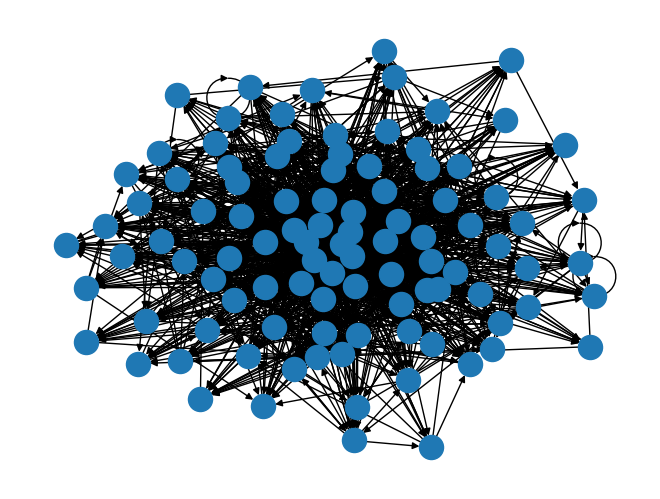

Streaming output truncated to the last 5000 lines.
7853 	 7 	 118 		 0.04036948340745809 	 R1 	 D1 	 B2 B14 B3 B1 B19 B11 B4
7854 	 7 	 118 		 0.04036948340745809 	 R1 	 D1 	 B2 B14 B3 B1 B19 B16 B4
7855 	 7 	 64 		 0.02189531303455354 	 R1 	 D1 	 B2 B14 B3 B1 B19 B16 B11
7856 	 7 	 27 		 0.009237085186452275 	 R1 	 D1 	 B2 B14 B3 B1 B16 B4 B34
7857 	 7 	 27 		 0.009237085186452275 	 R1 	 D1 	 B2 B14 B3 B1 B16 B4 B22
7858 	 7 	 54 		 0.01847417037290455 	 R1 	 D1 	 B2 B14 B3 B1 B16 B4 B12
7859 	 7 	 118 		 0.04036948340745809 	 R1 	 D1 	 B2 B14 B3 B1 B16 B11 B4
7860 	 7 	 118 		 0.04036948340745809 	 R1 	 D1 	 B2 B14 B3 B1 B27 B16 B4
7861 	 7 	 64 		 0.02189531303455354 	 R1 	 D1 	 B2 B14 B3 B1 B27 B16 B11
7862 	 7 	 78 		 0.02668491276086213 	 R1 	 D1 	 B2 B14 B3 B71 B1 B8 B6
7863 	 7 	 50 		 0.017105713308244955 	 R1 	 D1 	 B2 B14 B3 B71 B1 B6 B18
7864 	 7 	 69 		 0.023605884365378037 	 R1 	 D1 	 B2 B14 B3 B71 B1 B6 B8
7865 	 7 	 45 		 0.015395141977420458 	 R1 	 D1 	 B2 B14 B3 B71 B

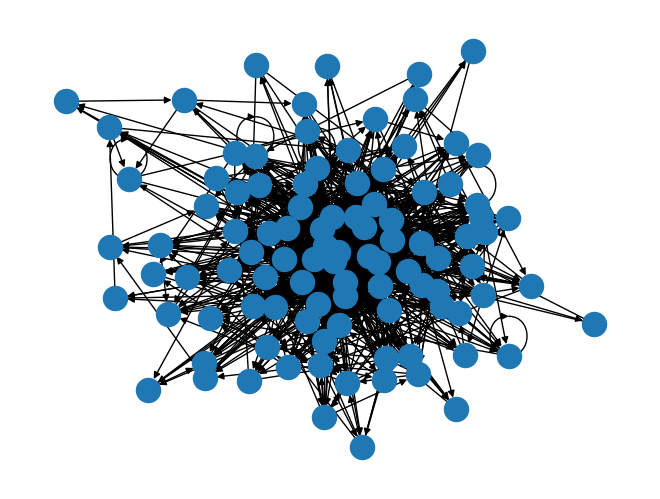

List of Frequent Patterns R1D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 6 	 44 		 0.02691131498470948 	 R1 	 D2 	 B29 B3 B35 B1 B8 B6
1 	 6 	 39 		 0.023853211009174313 	 R1 	 D2 	 B29 B3 B35 B1 B6 B8
2 	 6 	 44 		 0.02691131498470948 	 R1 	 D2 	 B2 B3 B35 B1 B8 B6
3 	 6 	 39 		 0.023853211009174313 	 R1 	 D2 	 B2 B3 B35 B1 B6 B8
4 	 6 	 44 		 0.02691131498470948 	 R1 	 D2 	 B17 B3 B35 B1 B8 B6
5 	 6 	 39 		 0.023853211009174313 	 R1 	 D2 	 B17 B3 B35 B1 B6 B8
6 	 5 	 44 		 0.02691131498470948 	 R1 	 D2 	 B3 B35 B1 B8 B6
7 	 5 	 39 		 0.023853211009174313 	 R1 	 D2 	 B3 B35 B1 B6 B8
8 	 5 	 44 		 0.02691131498470948 	 R1 	 D2 	 B29 B3 B1 B8 B6
9 	 5 	 39 		 0.023853211009174313 	 R1 	 D2 	 B29 B3 B1 B6 B8
10 	 5 	 24 		 0.014678899082568808 	 R1 	 D2 	 B29 B3 B35 B1 B19
11 	 5 	 39 		 0.023853211009174313 	 R1 	 D2 	 B29 B3 B35 B1 B8
12 	 5 	 10 		 0.0061162079510703364 	 R1 	 D2 	 B29 B3 B35 B1 B48
13 	 5 	 21 		 0.012844036697247707 	 R1 	 D2 	 B29 B3 B35 B1 B13
1

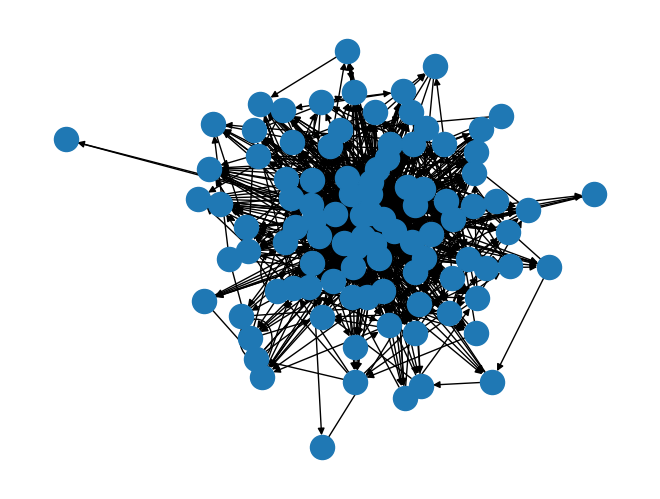

List of Frequent Patterns R1D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 5 	 45 		 0.02895752895752896 	 R1 	 D3 	 B2 B7 B9 B5 B10
1 	 5 	 23 		 0.014800514800514801 	 R1 	 D3 	 B24 B3 B1 B8 B13
2 	 5 	 15 		 0.009652509652509652 	 R1 	 D3 	 B24 B3 B1 B8 B27
3 	 4 	 45 		 0.02895752895752896 	 R1 	 D3 	 B2 B7 B9 B10
4 	 4 	 52 		 0.03346203346203346 	 R1 	 D3 	 B2 B7 B9 B5
5 	 4 	 45 		 0.02895752895752896 	 R1 	 D3 	 B2 B7 B5 B10
6 	 4 	 45 		 0.02895752895752896 	 R1 	 D3 	 B2 B9 B5 B10
7 	 4 	 23 		 0.014800514800514801 	 R1 	 D3 	 B35 B1 B8 B13
8 	 4 	 15 		 0.009652509652509652 	 R1 	 D3 	 B35 B1 B8 B27
9 	 4 	 23 		 0.014800514800514801 	 R1 	 D3 	 B3 B1 B8 B13
10 	 4 	 15 		 0.009652509652509652 	 R1 	 D3 	 B3 B1 B8 B27
11 	 4 	 45 		 0.02895752895752896 	 R1 	 D3 	 B7 B9 B5 B10
12 	 4 	 16 		 0.010296010296010296 	 R1 	 D3 	 B24 B3 B1 B28
13 	 4 	 40 		 0.02574002574002574 	 R1 	 D3 	 B24 B3 B1 B6
14 	 4 	 14 		 0.009009009009009009 	 R1 	 D3 	 B24 B3 B1 B48


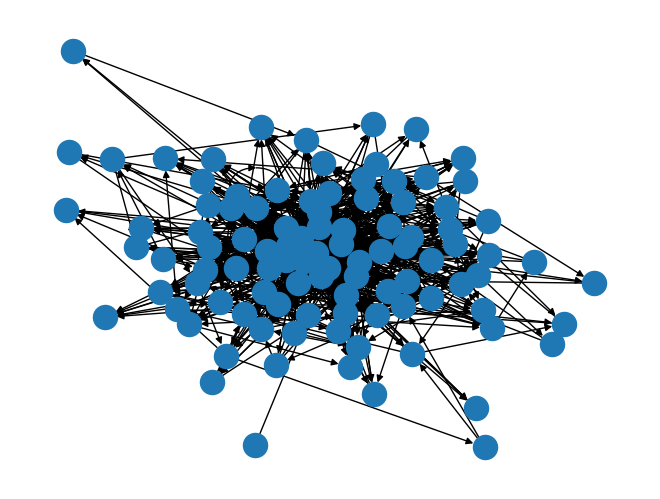

List of Frequent Patterns R1D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 45 		 0.03737541528239203 	 R1 	 D4 	 B3 B1 B6
1 	 3 	 32 		 0.026578073089700997 	 R1 	 D4 	 B3 B1 B8
2 	 3 	 18 		 0.014950166112956811 	 R1 	 D4 	 B3 B1 B27
3 	 3 	 9 		 0.007475083056478406 	 R1 	 D4 	 B3 B1 B28
4 	 3 	 16 		 0.013289036544850499 	 R1 	 D4 	 B3 B1 B21
5 	 3 	 20 		 0.016611295681063124 	 R1 	 D4 	 B11 B4 B12
6 	 3 	 45 		 0.03737541528239203 	 R1 	 D4 	 B29 B1 B6
7 	 3 	 32 		 0.026578073089700997 	 R1 	 D4 	 B29 B1 B8
8 	 3 	 18 		 0.014950166112956811 	 R1 	 D4 	 B29 B1 B27
9 	 3 	 9 		 0.007475083056478406 	 R1 	 D4 	 B29 B1 B28
10 	 3 	 16 		 0.013289036544850499 	 R1 	 D4 	 B29 B1 B21
11 	 3 	 45 		 0.03737541528239203 	 R1 	 D4 	 B2 B1 B6
12 	 3 	 32 		 0.026578073089700997 	 R1 	 D4 	 B2 B1 B8
13 	 3 	 18 		 0.014950166112956811 	 R1 	 D4 	 B2 B1 B27
14 	 3 	 9 		 0.007475083056478406 	 R1 	 D4 	 B2 B1 B28
15 	 3 	 16 		 0.013289036544850499 	 R1 	 D4 	 B2 B1 B21


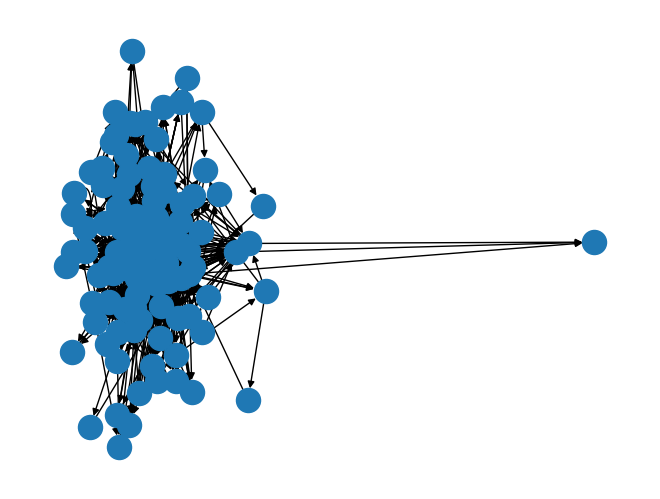

List of Frequent Patterns R1D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B3 B1 B6
1 	 3 	 12 		 0.012875536480686695 	 R1 	 D5 	 B3 B1 B21
2 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B3 B1 B8
3 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B20 B1 B6
4 	 3 	 12 		 0.012875536480686695 	 R1 	 D5 	 B20 B1 B21
5 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B20 B1 B8
6 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B24 B1 B6
7 	 3 	 12 		 0.012875536480686695 	 R1 	 D5 	 B24 B1 B21
8 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B24 B1 B8
9 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B35 B1 B6
10 	 3 	 12 		 0.012875536480686695 	 R1 	 D5 	 B35 B1 B21
11 	 3 	 29 		 0.03111587982832618 	 R1 	 D5 	 B35 B1 B8
12 	 2 	 39 		 0.04184549356223176 	 R1 	 D5 	 B2 B5
13 	 2 	 25 		 0.02682403433476395 	 R1 	 D5 	 B2 B7
14 	 2 	 21 		 0.022532188841201718 	 R1 	 D5 	 B2 B9
15 	 2 	 83 		 0.0890557939914163 	 R1 	 D5 	 B3 B1
16 	 2 	 9 		 0.00965

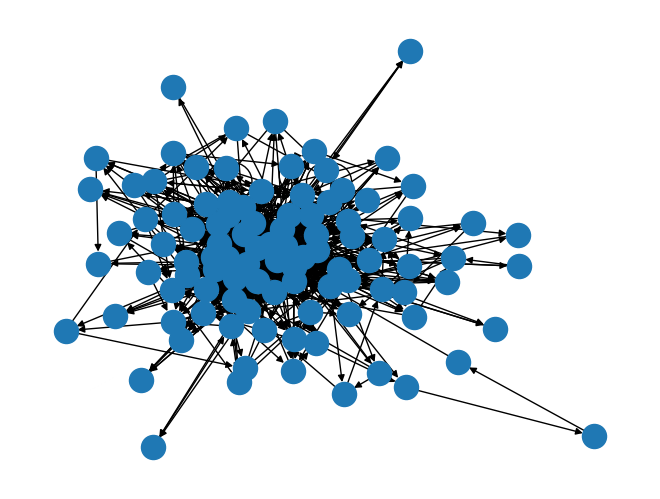

List of Frequent Patterns R1D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 5 	 25 		 0.02986857825567503 	 R1 	 D6 	 B2 B17 B3 B1 B8
1 	 5 	 14 		 0.016726403823178016 	 R1 	 D6 	 B2 B17 B3 B1 B21
2 	 5 	 26 		 0.03106332138590203 	 R1 	 D6 	 B2 B17 B3 B1 B6
3 	 4 	 83 		 0.0991636798088411 	 R1 	 D6 	 B2 B17 B3 B1
4 	 4 	 25 		 0.02986857825567503 	 R1 	 D6 	 B23 B3 B1 B8
5 	 4 	 14 		 0.016726403823178016 	 R1 	 D6 	 B23 B3 B1 B21
6 	 4 	 26 		 0.03106332138590203 	 R1 	 D6 	 B23 B3 B1 B6
7 	 4 	 25 		 0.02986857825567503 	 R1 	 D6 	 B17 B3 B1 B8
8 	 4 	 14 		 0.016726403823178016 	 R1 	 D6 	 B17 B3 B1 B21
9 	 4 	 26 		 0.03106332138590203 	 R1 	 D6 	 B17 B3 B1 B6
10 	 3 	 25 		 0.02986857825567503 	 R1 	 D6 	 B3 B1 B8
11 	 3 	 14 		 0.016726403823178016 	 R1 	 D6 	 B3 B1 B21
12 	 3 	 26 		 0.03106332138590203 	 R1 	 D6 	 B3 B1 B6
13 	 3 	 25 		 0.02986857825567503 	 R1 	 D6 	 B24 B1 B8
14 	 3 	 14 		 0.016726403823178016 	 R1 	 D6 	 B24 B1 B21
15 	 3 	 26 		 0.03106

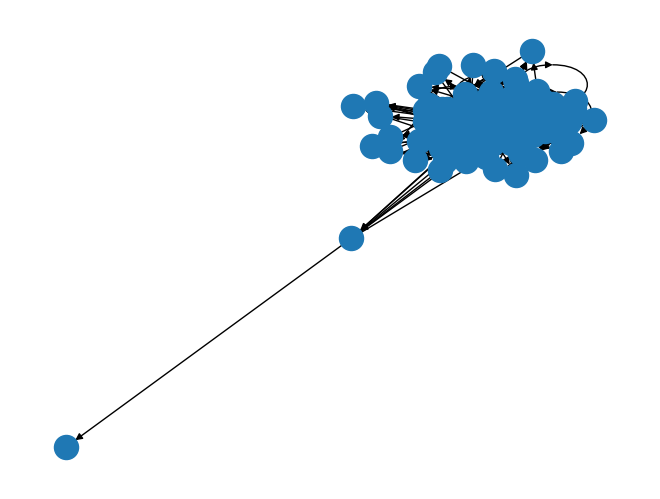

List of Frequent Patterns R1D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 5 	 26 		 0.03106332138590203 	 R1 	 D7 	 B7 B2 B9 B1 B6
1 	 5 	 8 		 0.009557945041816009 	 R1 	 D7 	 B7 B2 B9 B1 B48
2 	 5 	 20 		 0.023894862604540025 	 R1 	 D7 	 B7 B2 B9 B1 B8
3 	 5 	 12 		 0.014336917562724014 	 R1 	 D7 	 B7 B2 B9 B1 B21
4 	 4 	 26 		 0.03106332138590203 	 R1 	 D7 	 B2 B9 B1 B6
5 	 4 	 8 		 0.009557945041816009 	 R1 	 D7 	 B2 B9 B1 B48
6 	 4 	 20 		 0.023894862604540025 	 R1 	 D7 	 B2 B9 B1 B8
7 	 4 	 12 		 0.014336917562724014 	 R1 	 D7 	 B2 B9 B1 B21
8 	 4 	 76 		 0.0908004778972521 	 R1 	 D7 	 B7 B2 B9 B1
9 	 4 	 26 		 0.03106332138590203 	 R1 	 D7 	 B24 B3 B1 B6
10 	 4 	 8 		 0.009557945041816009 	 R1 	 D7 	 B24 B3 B1 B48
11 	 4 	 20 		 0.023894862604540025 	 R1 	 D7 	 B24 B3 B1 B8
12 	 4 	 12 		 0.014336917562724014 	 R1 	 D7 	 B24 B3 B1 B21
13 	 3 	 76 		 0.0908004778972521 	 R1 	 D7 	 B2 B9 B1
14 	 3 	 20 		 0.023894862604540025 	 R1 	 D7 	 B7 B2 B5
15 	 3 	 22 		 0

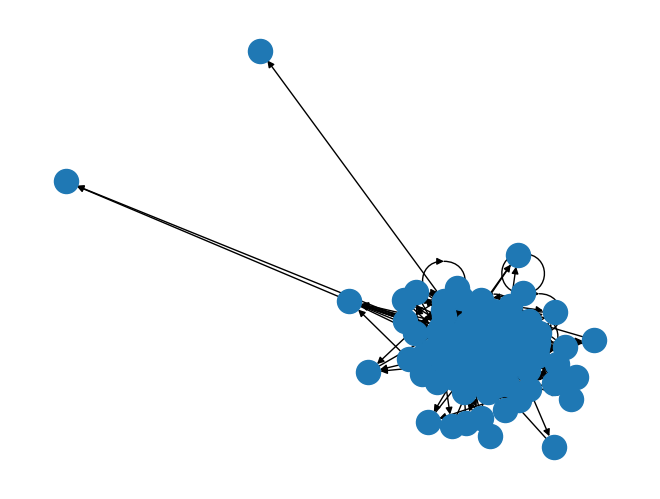

List of Frequent Patterns R1D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 22 		 0.029850746268656716 	 R1 	 D8 	 B3 B1 B11
1 	 3 	 20 		 0.027137042062415198 	 R1 	 D8 	 B3 B1 B6
2 	 3 	 18 		 0.024423337856173677 	 R1 	 D8 	 B3 B1 B8
3 	 3 	 24 		 0.032564450474898234 	 R1 	 D8 	 B7 B2 B5
4 	 3 	 22 		 0.029850746268656716 	 R1 	 D8 	 B7 B2 B10
5 	 3 	 22 		 0.029850746268656716 	 R1 	 D8 	 B20 B1 B11
6 	 3 	 20 		 0.027137042062415198 	 R1 	 D8 	 B20 B1 B6
7 	 3 	 18 		 0.024423337856173677 	 R1 	 D8 	 B20 B1 B8
8 	 2 	 69 		 0.09362279511533243 	 R1 	 D8 	 B3 B1
9 	 2 	 22 		 0.029850746268656716 	 R1 	 D8 	 B1 B11
10 	 2 	 20 		 0.027137042062415198 	 R1 	 D8 	 B1 B6
11 	 2 	 18 		 0.024423337856173677 	 R1 	 D8 	 B1 B8
12 	 2 	 24 		 0.032564450474898234 	 R1 	 D8 	 B2 B5
13 	 2 	 22 		 0.029850746268656716 	 R1 	 D8 	 B2 B10
14 	 2 	 54 		 0.07327001356852103 	 R1 	 D8 	 B7 B2
15 	 2 	 69 		 0.09362279511533243 	 R1 	 D8 	 B20 B1


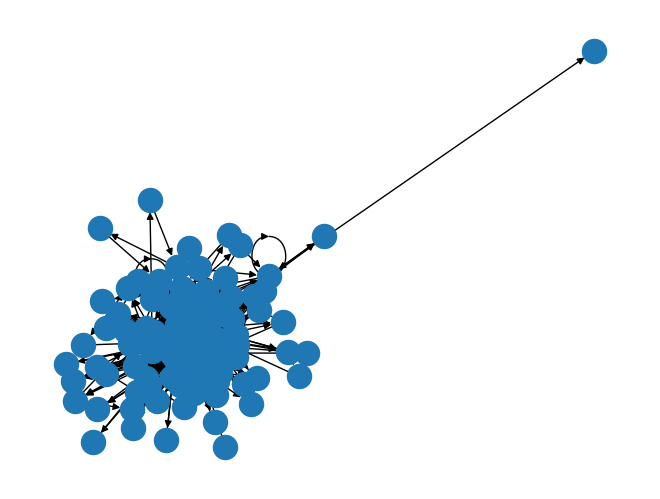

List of Frequent Patterns R1D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 24 		 0.046153846153846156 	 R1 	 D9 	 B3 B1 B6
1 	 3 	 22 		 0.04230769230769231 	 R1 	 D9 	 B3 B1 B8
2 	 3 	 24 		 0.046153846153846156 	 R1 	 D9 	 B35 B1 B6
3 	 3 	 22 		 0.04230769230769231 	 R1 	 D9 	 B35 B1 B8
4 	 2 	 59 		 0.11346153846153846 	 R1 	 D9 	 B3 B1
5 	 2 	 24 		 0.046153846153846156 	 R1 	 D9 	 B1 B6
6 	 2 	 22 		 0.04230769230769231 	 R1 	 D9 	 B1 B8
7 	 2 	 26 		 0.05 	 R1 	 D9 	 B2 B9
8 	 2 	 24 		 0.046153846153846156 	 R1 	 D9 	 B2 B5
9 	 2 	 59 		 0.11346153846153846 	 R1 	 D9 	 B35 B1


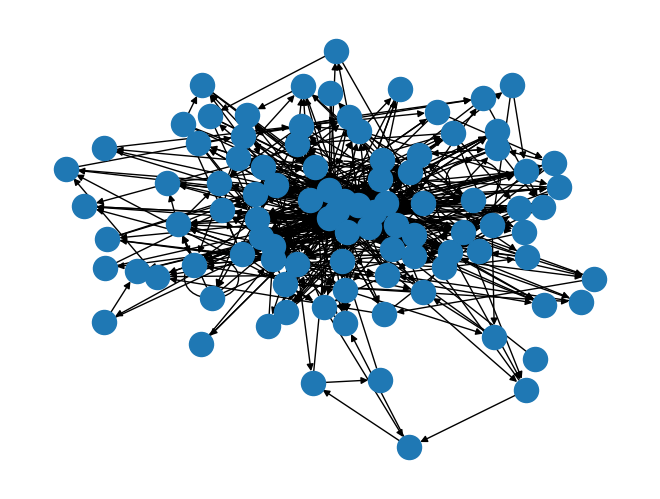

List of Frequent Patterns R1D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 11 		 0.019230769230769232 	 R1 	 D10 	 B3 B1 B28
1 	 3 	 14 		 0.024475524475524476 	 R1 	 D10 	 B3 B1 B8
2 	 2 	 11 		 0.019230769230769232 	 R1 	 D10 	 B1 B28
3 	 2 	 14 		 0.024475524475524476 	 R1 	 D10 	 B1 B8
4 	 2 	 15 		 0.026223776223776224 	 R1 	 D10 	 B2 B9
5 	 2 	 67 		 0.11713286713286714 	 R1 	 D10 	 B3 B1


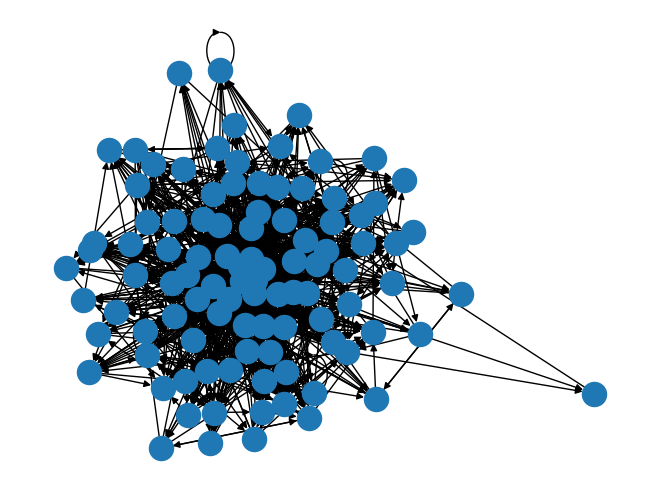

List of Frequent Patterns R2D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 8 	 22 		 0.011470281543274244 	 R2 	 D1 	 B2 B7 B5 B3 B1 B11 B4 B22
1 	 8 	 22 		 0.011470281543274244 	 R2 	 D1 	 B7 B2 B5 B3 B1 B11 B4 B22
2 	 7 	 22 		 0.011470281543274244 	 R2 	 D1 	 B2 B5 B3 B1 B11 B4 B22
3 	 7 	 22 		 0.011470281543274244 	 R2 	 D1 	 B2 B7 B5 B1 B11 B4 B22
4 	 7 	 47 		 0.024504692387904068 	 R2 	 D1 	 B2 B7 B5 B3 B1 B8 B6
5 	 7 	 67 		 0.034932221063607924 	 R2 	 D1 	 B2 B7 B5 B3 B1 B11 B4
6 	 7 	 22 		 0.011470281543274244 	 R2 	 D1 	 B7 B5 B3 B1 B11 B4 B22
7 	 7 	 22 		 0.011470281543274244 	 R2 	 D1 	 B7 B2 B3 B1 B11 B4 B22
8 	 7 	 22 		 0.011470281543274244 	 R2 	 D1 	 B7 B2 B5 B1 B11 B4 B22
9 	 7 	 47 		 0.024504692387904068 	 R2 	 D1 	 B7 B2 B5 B3 B1 B8 B6
10 	 7 	 67 		 0.034932221063607924 	 R2 	 D1 	 B7 B2 B5 B3 B1 B11 B4
11 	 6 	 22 		 0.011470281543274244 	 R2 	 D1 	 B2 B3 B1 B11 B4 B22
12 	 6 	 22 		 0.011470281543274244 	 R2 	 D1 	 B2 B5 B1 B11 B4 B22
13 	 

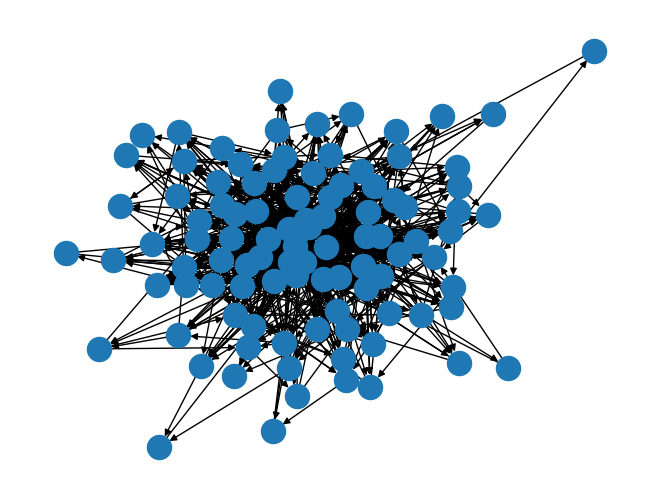

List of Frequent Patterns R2D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 4 	 22 		 0.01765650080256822 	 R2 	 D2 	 B23 B3 B1 B13
1 	 4 	 34 		 0.027287319422150885 	 R2 	 D2 	 B23 B3 B1 B6
2 	 4 	 32 		 0.025682182985553772 	 R2 	 D2 	 B23 B3 B1 B8
3 	 4 	 14 		 0.011235955056179775 	 R2 	 D2 	 B23 B3 B1 B21
4 	 4 	 13 		 0.01043338683788122 	 R2 	 D2 	 B23 B3 B1 B28
5 	 4 	 41 		 0.03290529695024077 	 R2 	 D2 	 B15 B2 B9 B5
6 	 4 	 22 		 0.01765650080256822 	 R2 	 D2 	 B25 B3 B1 B13
7 	 4 	 34 		 0.027287319422150885 	 R2 	 D2 	 B25 B3 B1 B6
8 	 4 	 32 		 0.025682182985553772 	 R2 	 D2 	 B25 B3 B1 B8
9 	 4 	 14 		 0.011235955056179775 	 R2 	 D2 	 B25 B3 B1 B21
10 	 4 	 13 		 0.01043338683788122 	 R2 	 D2 	 B25 B3 B1 B28
11 	 4 	 22 		 0.01765650080256822 	 R2 	 D2 	 B24 B3 B1 B13
12 	 4 	 34 		 0.027287319422150885 	 R2 	 D2 	 B24 B3 B1 B6
13 	 4 	 32 		 0.025682182985553772 	 R2 	 D2 	 B24 B3 B1 B8
14 	 4 	 14 		 0.011235955056179775 	 R2 	 D2 	 B24 B3 B1 B21
15 	 

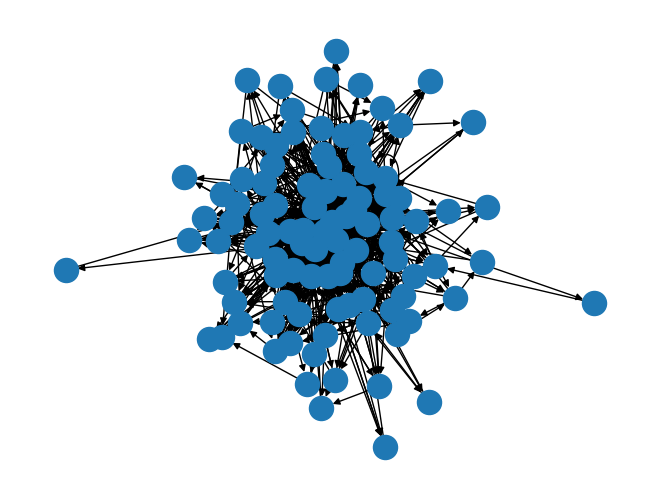

List of Frequent Patterns R2D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 35 		 0.03219871205151794 	 R2 	 D3 	 B29 B1 B6
1 	 3 	 24 		 0.02207911683532659 	 R2 	 D3 	 B29 B1 B8
2 	 3 	 16 		 0.014719411223551058 	 R2 	 D3 	 B29 B1 B28
3 	 3 	 53 		 0.04875804967801288 	 R2 	 D3 	 B29 B1 B4
4 	 3 	 22 		 0.020239190432382703 	 R2 	 D3 	 B29 B1 B16
5 	 3 	 35 		 0.03219871205151794 	 R2 	 D3 	 B3 B1 B6
6 	 3 	 24 		 0.02207911683532659 	 R2 	 D3 	 B3 B1 B8
7 	 3 	 16 		 0.014719411223551058 	 R2 	 D3 	 B3 B1 B28
8 	 3 	 53 		 0.04875804967801288 	 R2 	 D3 	 B3 B1 B4
9 	 3 	 22 		 0.020239190432382703 	 R2 	 D3 	 B3 B1 B16
10 	 3 	 35 		 0.03219871205151794 	 R2 	 D3 	 B20 B1 B6
11 	 3 	 24 		 0.02207911683532659 	 R2 	 D3 	 B20 B1 B8
12 	 3 	 16 		 0.014719411223551058 	 R2 	 D3 	 B20 B1 B28
13 	 3 	 53 		 0.04875804967801288 	 R2 	 D3 	 B20 B1 B4
14 	 3 	 22 		 0.020239190432382703 	 R2 	 D3 	 B20 B1 B16
15 	 3 	 35 		 0.03219871205151794 	 R2 	 D3 	 B17 B1 B6
16 

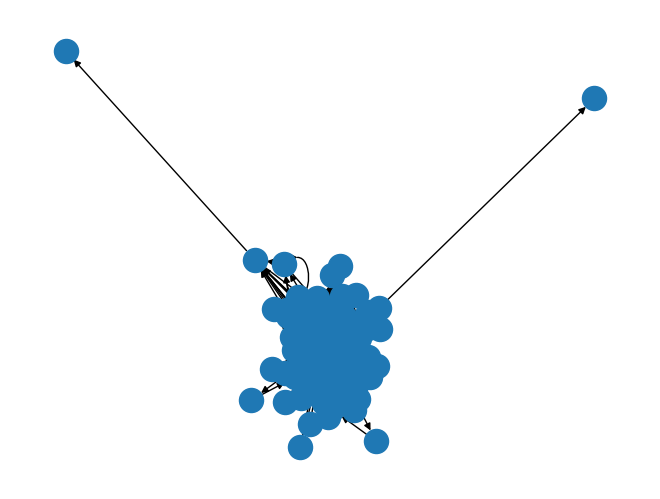

List of Frequent Patterns R2D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 20 		 0.029154518950437316 	 R2 	 D4 	 B3 B1 B8
1 	 3 	 20 		 0.029154518950437316 	 R2 	 D4 	 B3 B1 B6
2 	 3 	 20 		 0.029154518950437316 	 R2 	 D4 	 B23 B1 B8
3 	 3 	 20 		 0.029154518950437316 	 R2 	 D4 	 B23 B1 B6
4 	 2 	 14 		 0.02040816326530612 	 R2 	 D4 	 B4 B12
5 	 2 	 20 		 0.029154518950437316 	 R2 	 D4 	 B1 B8
6 	 2 	 20 		 0.029154518950437316 	 R2 	 D4 	 B1 B6
7 	 2 	 31 		 0.04518950437317784 	 R2 	 D4 	 B2 B5
8 	 2 	 59 		 0.08600583090379009 	 R2 	 D4 	 B3 B1
9 	 2 	 59 		 0.08600583090379009 	 R2 	 D4 	 B23 B1


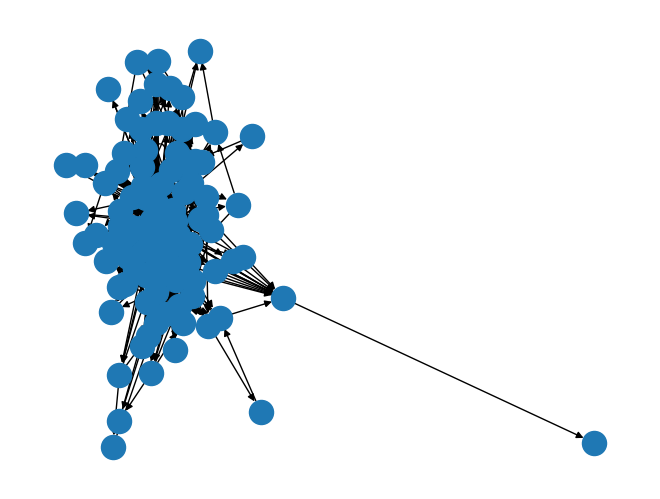

List of Frequent Patterns R2D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 4 	 18 		 0.03220035778175313 	 R2 	 D5 	 B15 B5 B1 B8
1 	 4 	 22 		 0.03935599284436494 	 R2 	 D5 	 B15 B5 B1 B6
2 	 4 	 18 		 0.03220035778175313 	 R2 	 D5 	 B2 B5 B1 B8
3 	 4 	 22 		 0.03935599284436494 	 R2 	 D5 	 B2 B5 B1 B6
4 	 4 	 18 		 0.03220035778175313 	 R2 	 D5 	 B17 B3 B1 B8
5 	 4 	 22 		 0.03935599284436494 	 R2 	 D5 	 B17 B3 B1 B6
6 	 4 	 18 		 0.03220035778175313 	 R2 	 D5 	 B24 B3 B1 B8
7 	 4 	 22 		 0.03935599284436494 	 R2 	 D5 	 B24 B3 B1 B6
8 	 3 	 18 		 0.03220035778175313 	 R2 	 D5 	 B3 B1 B8
9 	 3 	 22 		 0.03935599284436494 	 R2 	 D5 	 B3 B1 B6
10 	 3 	 58 		 0.1037567084078712 	 R2 	 D5 	 B15 B5 B1
11 	 3 	 9 		 0.016100178890876567 	 R2 	 D5 	 B15 B5 B14
12 	 3 	 18 		 0.03220035778175313 	 R2 	 D5 	 B5 B1 B8
13 	 3 	 22 		 0.03935599284436494 	 R2 	 D5 	 B5 B1 B6
14 	 3 	 58 		 0.1037567084078712 	 R2 	 D5 	 B2 B5 B1
15 	 3 	 9 		 0.016100178890876567 	 R2 	 D5 	 B2 B

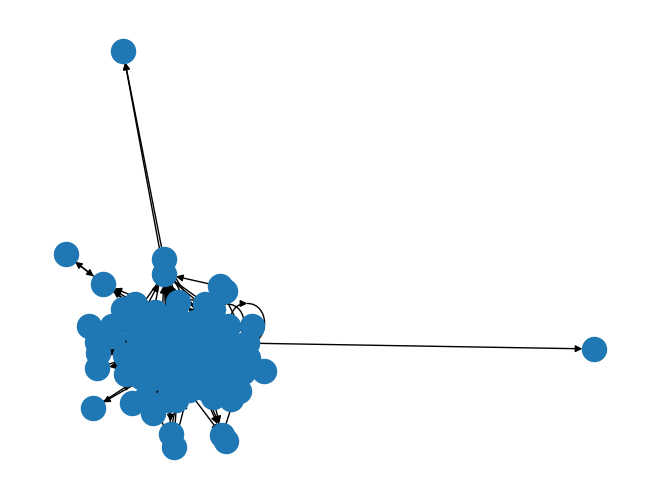

List of Frequent Patterns R2D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 4 	 15 		 0.03480278422273782 	 R2 	 D6 	 B3 B1 B8 B6
1 	 3 	 15 		 0.03480278422273782 	 R2 	 D6 	 B1 B8 B6
2 	 3 	 17 		 0.03944315545243619 	 R2 	 D6 	 B3 B1 B8
3 	 2 	 15 		 0.03480278422273782 	 R2 	 D6 	 B8 B6
4 	 2 	 17 		 0.03944315545243619 	 R2 	 D6 	 B1 B8
5 	 2 	 16 		 0.037122969837587005 	 R2 	 D6 	 B2 B5
6 	 2 	 19 		 0.04408352668213457 	 R2 	 D6 	 B2 B9
7 	 2 	 47 		 0.10904872389791183 	 R2 	 D6 	 B3 B1


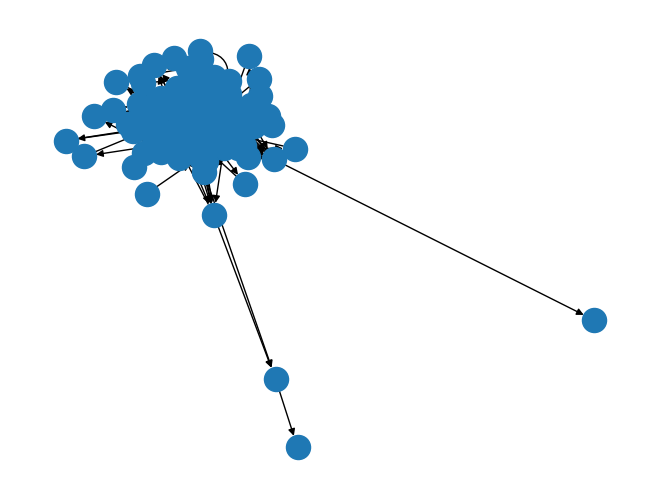

List of Frequent Patterns R2D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 19 		 0.03718199608610567 	 R2 	 D7 	 B3 B1 B6
1 	 2 	 19 		 0.03718199608610567 	 R2 	 D7 	 B1 B6
2 	 2 	 15 		 0.029354207436399216 	 R2 	 D7 	 B2 B5
3 	 2 	 14 		 0.0273972602739726 	 R2 	 D7 	 B2 B10
4 	 2 	 50 		 0.09784735812133072 	 R2 	 D7 	 B3 B1


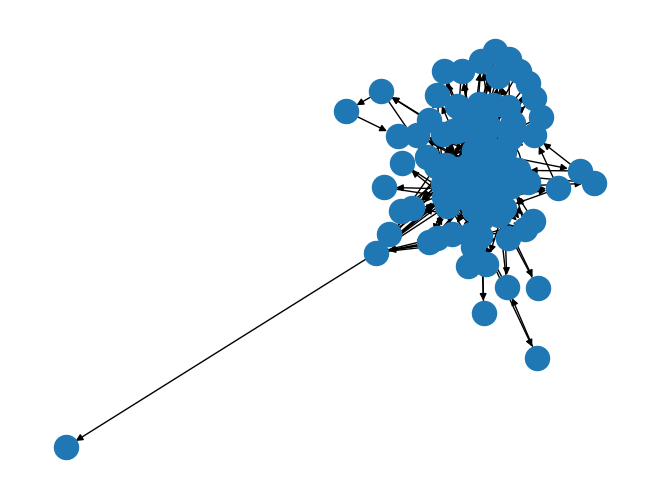

List of Frequent Patterns R2D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 11 		 0.039568345323741004 	 R2 	 D8 	 B3 B1 B8
1 	 3 	 16 		 0.05755395683453238 	 R2 	 D8 	 B3 B1 B6
2 	 2 	 34 		 0.1223021582733813 	 R2 	 D8 	 B3 B1
3 	 2 	 11 		 0.039568345323741004 	 R2 	 D8 	 B1 B8
4 	 2 	 16 		 0.05755395683453238 	 R2 	 D8 	 B1 B6


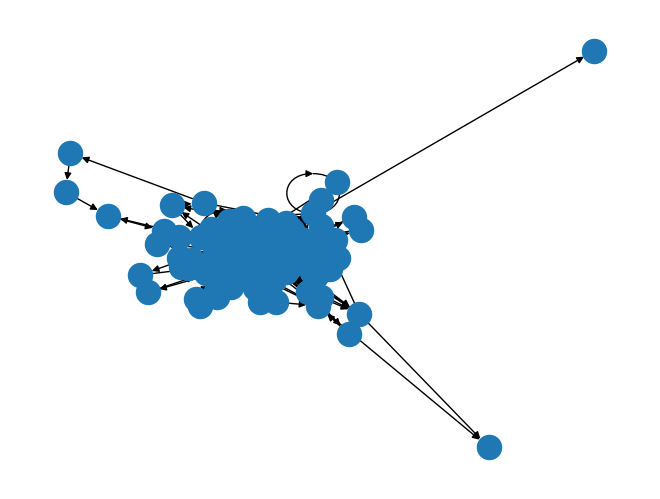

List of Frequent Patterns R2D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 16 		 0.05536332179930796 	 R2 	 D9 	 B3 B1 B8
1 	 2 	 34 		 0.11764705882352941 	 R2 	 D9 	 B3 B1
2 	 2 	 20 		 0.06920415224913495 	 R2 	 D9 	 B2 B5
3 	 2 	 12 		 0.04152249134948097 	 R2 	 D9 	 B2 B9
4 	 2 	 16 		 0.05536332179930796 	 R2 	 D9 	 B1 B8


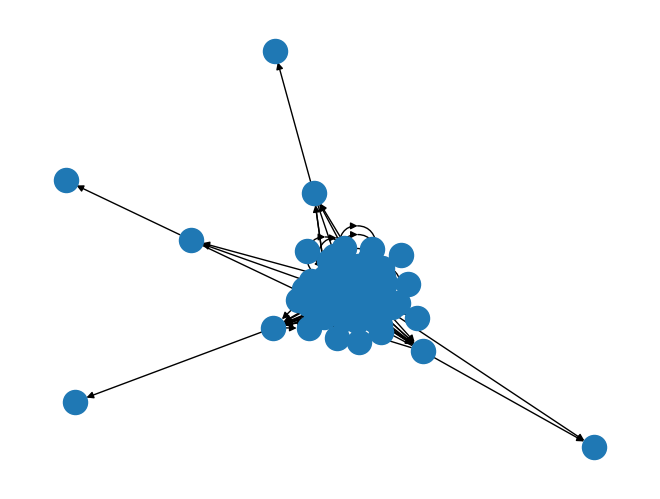

List of Frequent Patterns R2D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 6 		 0.014598540145985401 	 R2 	 D10 	 B3 B1 B28
1 	 2 	 6 		 0.014598540145985401 	 R2 	 D10 	 B1 B28
2 	 2 	 42 		 0.10218978102189781 	 R2 	 D10 	 B3 B1


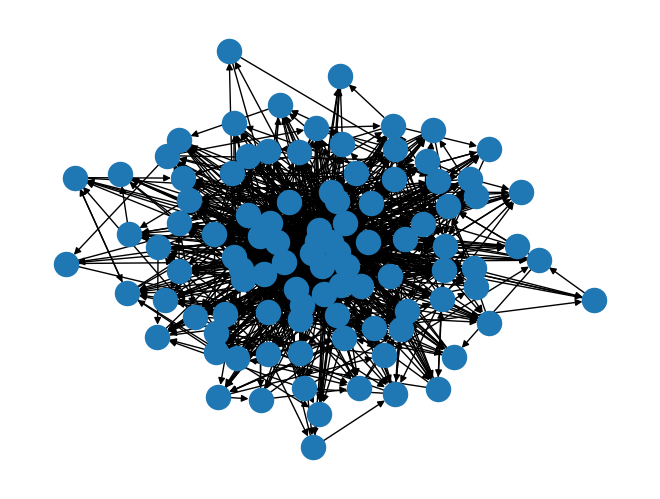

List of Frequent Patterns R3D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 6 	 26 		 0.0152046783625731 	 R3 	 D1 	 B20 B3 B1 B6 B13 B18
1 	 6 	 26 		 0.0152046783625731 	 R3 	 D1 	 B23 B3 B1 B6 B13 B18
2 	 6 	 26 		 0.0152046783625731 	 R3 	 D1 	 B38 B3 B1 B6 B13 B18
3 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B63 B1 B6 B13 B18
4 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B3 B1 B6 B13 B18
5 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B17 B1 B6 B13 B18
6 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B20 B1 B6 B13 B18
7 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B20 B3 B1 B13 B18
8 	 5 	 33 		 0.01929824561403509 	 R3 	 D1 	 B20 B3 B1 B6 B13
9 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B23 B1 B6 B13 B18
10 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B23 B3 B1 B13 B18
11 	 5 	 33 		 0.01929824561403509 	 R3 	 D1 	 B23 B3 B1 B6 B13
12 	 5 	 26 		 0.0152046783625731 	 R3 	 D1 	 B38 B3 B1 B13 B18
13 	 5 	 33 		 0.01929824561403509 	 R3 	 D1 	 B38 B3 B1 B6 B13
14 	 5 	 26 		 0.0

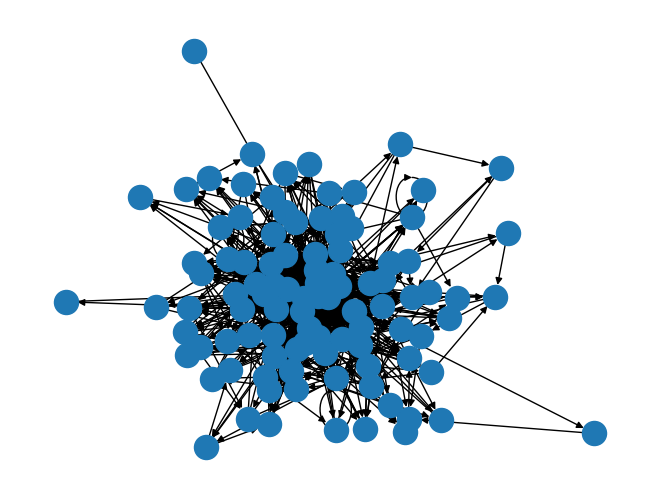

List of Frequent Patterns R3D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 28 		 0.028254288597376387 	 R3 	 D2 	 B3 B1 B8
1 	 3 	 13 		 0.013118062563067608 	 R3 	 D2 	 B3 B1 B28
2 	 3 	 9 		 0.009081735620585268 	 R3 	 D2 	 B3 B1 B48
3 	 3 	 26 		 0.026236125126135216 	 R3 	 D2 	 B3 B1 B6
4 	 3 	 15 		 0.015136226034308779 	 R3 	 D2 	 B3 B1 B21
5 	 3 	 42 		 0.04238143289606458 	 R3 	 D2 	 B2 B7 B5
6 	 3 	 28 		 0.028254288597376387 	 R3 	 D2 	 B10 B1 B8
7 	 3 	 13 		 0.013118062563067608 	 R3 	 D2 	 B10 B1 B28
8 	 3 	 9 		 0.009081735620585268 	 R3 	 D2 	 B10 B1 B48
9 	 3 	 26 		 0.026236125126135216 	 R3 	 D2 	 B10 B1 B6
10 	 3 	 15 		 0.015136226034308779 	 R3 	 D2 	 B10 B1 B21
11 	 3 	 42 		 0.04238143289606458 	 R3 	 D2 	 B7 B2 B5
12 	 3 	 28 		 0.028254288597376387 	 R3 	 D2 	 B23 B1 B8
13 	 3 	 13 		 0.013118062563067608 	 R3 	 D2 	 B23 B1 B28
14 	 3 	 9 		 0.009081735620585268 	 R3 	 D2 	 B23 B1 B48
15 	 3 	 26 		 0.026236125126135216 	 R3 	 D2 	 B23 B1 B

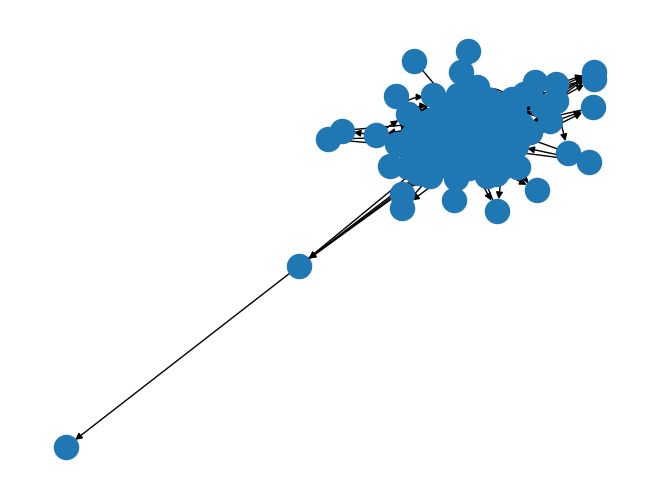

List of Frequent Patterns R3D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 11 		 0.020754716981132074 	 R3 	 D3 	 B3 B1 B8
1 	 3 	 22 		 0.04150943396226415 	 R3 	 D3 	 B3 B1 B6
2 	 2 	 11 		 0.020754716981132074 	 R3 	 D3 	 B1 B8
3 	 2 	 22 		 0.04150943396226415 	 R3 	 D3 	 B1 B6
4 	 2 	 22 		 0.04150943396226415 	 R3 	 D3 	 B2 B5
5 	 2 	 52 		 0.09811320754716982 	 R3 	 D3 	 B3 B1


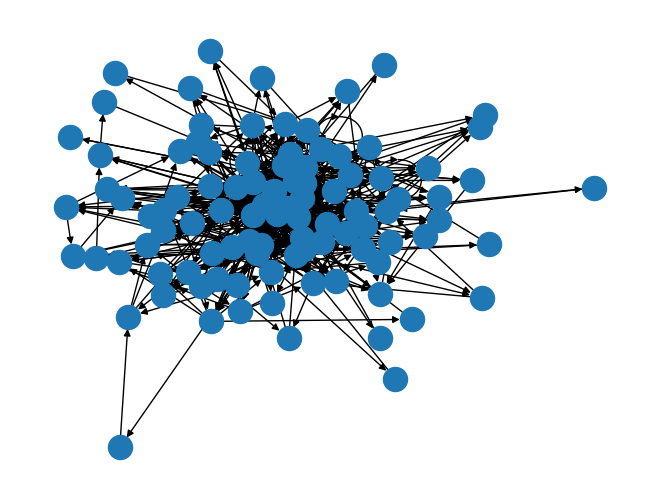

List of Frequent Patterns R3D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 27 		 0.044407894736842105 	 R3 	 D4 	 B3 B1 B6
1 	 3 	 13 		 0.02138157894736842 	 R3 	 D4 	 B3 B1 B21
2 	 3 	 8 		 0.013157894736842105 	 R3 	 D4 	 B3 B1 B48
3 	 3 	 27 		 0.044407894736842105 	 R3 	 D4 	 B20 B1 B6
4 	 3 	 13 		 0.02138157894736842 	 R3 	 D4 	 B20 B1 B21
5 	 3 	 8 		 0.013157894736842105 	 R3 	 D4 	 B20 B1 B48
6 	 3 	 27 		 0.044407894736842105 	 R3 	 D4 	 B35 B1 B6
7 	 3 	 13 		 0.02138157894736842 	 R3 	 D4 	 B35 B1 B21
8 	 3 	 8 		 0.013157894736842105 	 R3 	 D4 	 B35 B1 B48
9 	 2 	 13 		 0.02138157894736842 	 R3 	 D4 	 B2 B26
10 	 2 	 20 		 0.03289473684210526 	 R3 	 D4 	 B2 B9
11 	 2 	 22 		 0.03618421052631579 	 R3 	 D4 	 B2 B5
12 	 2 	 27 		 0.044407894736842105 	 R3 	 D4 	 B1 B6
13 	 2 	 13 		 0.02138157894736842 	 R3 	 D4 	 B1 B21
14 	 2 	 8 		 0.013157894736842105 	 R3 	 D4 	 B1 B48
15 	 2 	 67 		 0.11019736842105263 	 R3 	 D4 	 B3 B1
16 	 2 	 67 		 0.11019736842

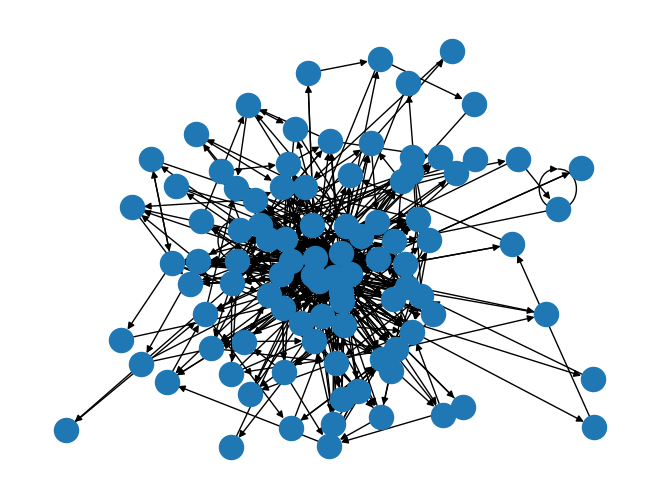

List of Frequent Patterns R3D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 20 		 0.038461538461538464 	 R3 	 D5 	 B3 B1 B6
1 	 3 	 13 		 0.025 	 R3 	 D5 	 B3 B1 B8
2 	 2 	 48 		 0.09230769230769231 	 R3 	 D5 	 B3 B1
3 	 2 	 20 		 0.038461538461538464 	 R3 	 D5 	 B1 B6
4 	 2 	 13 		 0.025 	 R3 	 D5 	 B1 B8
5 	 2 	 17 		 0.032692307692307694 	 R3 	 D5 	 B2 B9


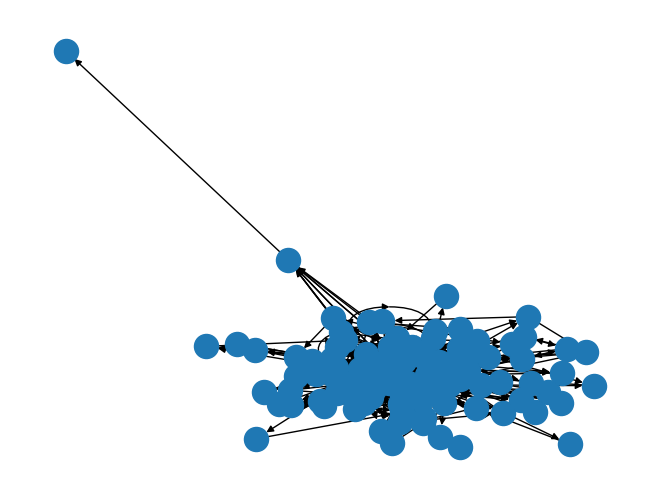

List of Frequent Patterns R3D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 18 		 0.04265402843601896 	 R3 	 D6 	 B3 B1 B6
1 	 3 	 10 		 0.023696682464454975 	 R3 	 D6 	 B3 B1 B8
2 	 3 	 18 		 0.04265402843601896 	 R3 	 D6 	 B35 B1 B6
3 	 3 	 10 		 0.023696682464454975 	 R3 	 D6 	 B35 B1 B8
4 	 2 	 53 		 0.12559241706161137 	 R3 	 D6 	 B3 B1
5 	 2 	 17 		 0.04028436018957346 	 R3 	 D6 	 B2 B5
6 	 2 	 18 		 0.04265402843601896 	 R3 	 D6 	 B1 B6
7 	 2 	 10 		 0.023696682464454975 	 R3 	 D6 	 B1 B8
8 	 2 	 53 		 0.12559241706161137 	 R3 	 D6 	 B35 B1


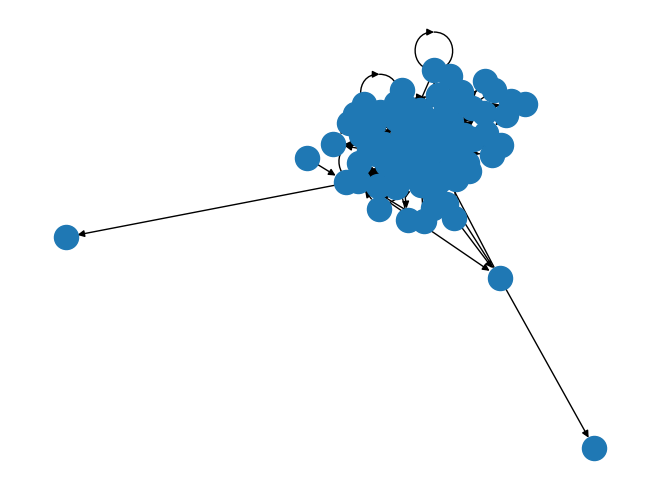

List of Frequent Patterns R3D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 14 		 0.05533596837944664 	 R3 	 D7 	 B1 B6


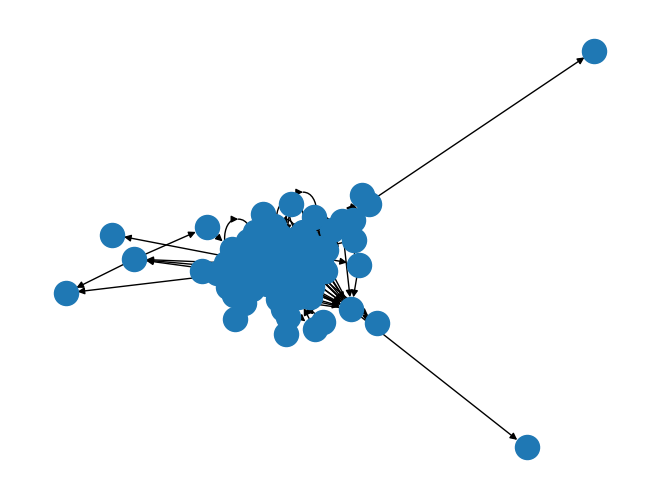

List of Frequent Patterns R3D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 13 		 0.05627705627705628 	 R3 	 D8 	 B3 B1 B8
1 	 2 	 13 		 0.05627705627705628 	 R3 	 D8 	 B1 B8
2 	 2 	 32 		 0.13852813852813853 	 R3 	 D8 	 B3 B1


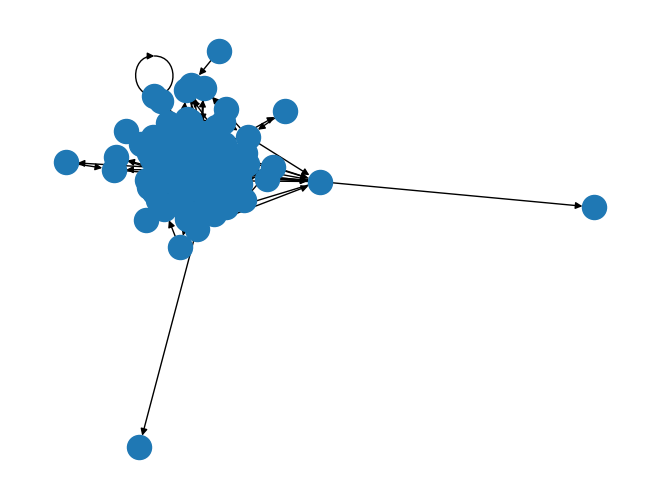

List of Frequent Patterns R3D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 16 		 0.0730593607305936 	 R3 	 D9 	 B2 B5


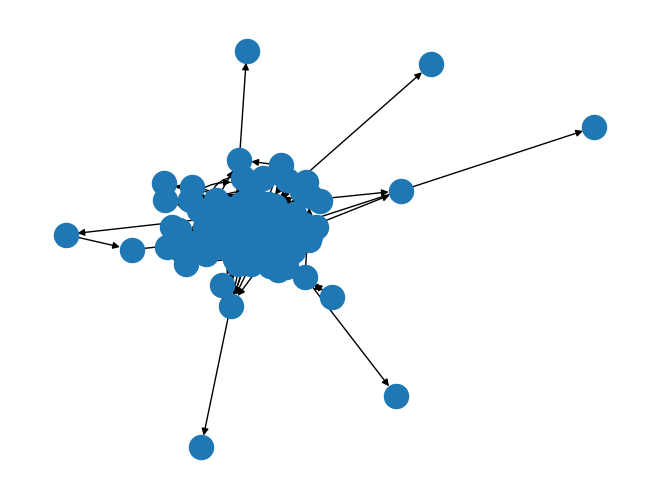

List of Frequent Patterns R3D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 30 		 0.15 	 R3 	 D10 	 B24 B3 B1
1 	 2 	 12 		 0.06 	 R3 	 D10 	 B2 B5
2 	 2 	 30 		 0.15 	 R3 	 D10 	 B3 B1
3 	 2 	 18 		 0.09 	 R3 	 D10 	 B24 B3


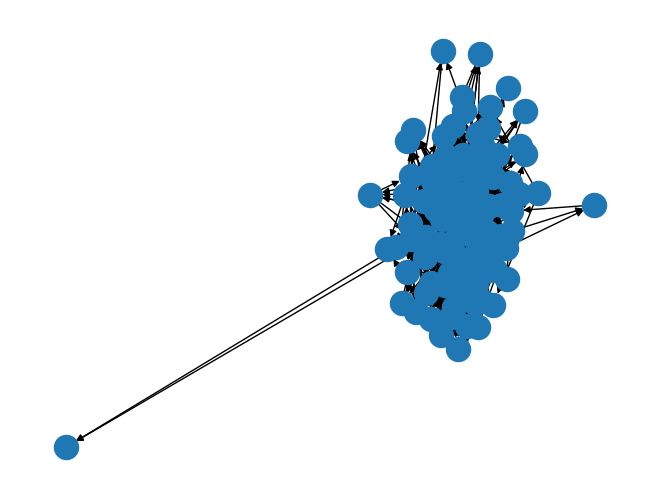

List of Frequent Patterns R4D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 5 	 39 		 0.03165584415584415 	 R4 	 D1 	 B17 B3 B1 B8 B6
1 	 4 	 39 		 0.03165584415584415 	 R4 	 D1 	 B3 B1 B8 B6
2 	 4 	 39 		 0.03165584415584415 	 R4 	 D1 	 B17 B3 B1 B6
3 	 4 	 31 		 0.025162337662337664 	 R4 	 D1 	 B17 B3 B1 B8
4 	 4 	 12 		 0.00974025974025974 	 R4 	 D1 	 B17 B3 B1 B63
5 	 4 	 39 		 0.03165584415584415 	 R4 	 D1 	 B20 B1 B8 B6
6 	 4 	 39 		 0.03165584415584415 	 R4 	 D1 	 B71 B1 B8 B6
7 	 4 	 39 		 0.03165584415584415 	 R4 	 D1 	 B35 B1 B8 B6
8 	 3 	 39 		 0.03165584415584415 	 R4 	 D1 	 B3 B1 B6
9 	 3 	 31 		 0.025162337662337664 	 R4 	 D1 	 B3 B1 B8
10 	 3 	 12 		 0.00974025974025974 	 R4 	 D1 	 B3 B1 B63
11 	 3 	 50 		 0.040584415584415584 	 R4 	 D1 	 B2 B9 B5
12 	 3 	 39 		 0.03165584415584415 	 R4 	 D1 	 B1 B8 B6
13 	 3 	 99 		 0.08035714285714286 	 R4 	 D1 	 B17 B3 B1
14 	 3 	 39 		 0.03165584415584415 	 R4 	 D1 	 B20 B1 B6
15 	 3 	 31 		 0.025162337662337664 	 R4 

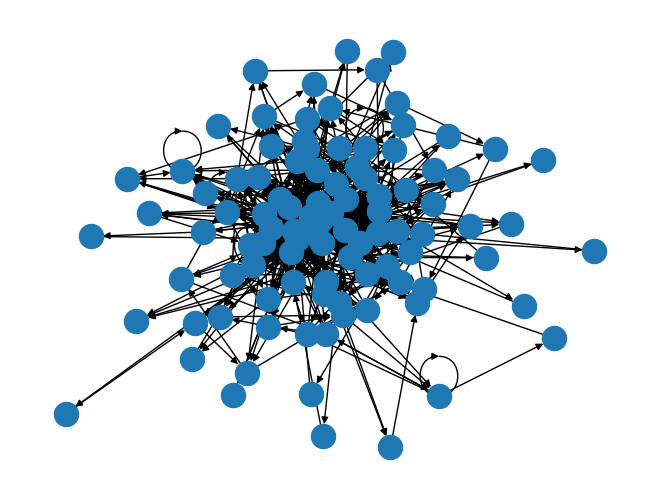

List of Frequent Patterns R4D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 4 	 35 		 0.048409405255878286 	 R4 	 D2 	 B3 B1 B8 B6
1 	 4 	 35 		 0.048409405255878286 	 R4 	 D2 	 B35 B1 B8 B6
2 	 4 	 35 		 0.048409405255878286 	 R4 	 D2 	 B47 B1 B8 B6
3 	 3 	 22 		 0.030428769017980636 	 R4 	 D2 	 B3 B1 B8
4 	 3 	 35 		 0.048409405255878286 	 R4 	 D2 	 B3 B1 B6
5 	 3 	 11 		 0.015214384508990318 	 R4 	 D2 	 B3 B1 B21
6 	 3 	 35 		 0.048409405255878286 	 R4 	 D2 	 B1 B8 B6
7 	 3 	 19 		 0.02627939142461964 	 R4 	 D2 	 B2 B5 B10
8 	 3 	 22 		 0.030428769017980636 	 R4 	 D2 	 B35 B1 B8
9 	 3 	 35 		 0.048409405255878286 	 R4 	 D2 	 B35 B1 B6
10 	 3 	 11 		 0.015214384508990318 	 R4 	 D2 	 B35 B1 B21
11 	 3 	 22 		 0.030428769017980636 	 R4 	 D2 	 B47 B1 B8
12 	 3 	 35 		 0.048409405255878286 	 R4 	 D2 	 B47 B1 B6
13 	 3 	 11 		 0.015214384508990318 	 R4 	 D2 	 B47 B1 B21
14 	 2 	 73 		 0.10096818810511757 	 R4 	 D2 	 B3 B1
15 	 2 	 22 		 0.030428769017980636 	 R4 	 D2 	 B1 

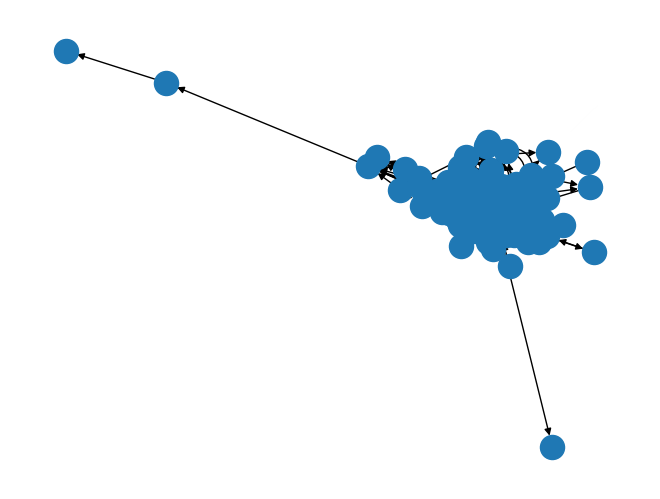

List of Frequent Patterns R4D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 15 		 0.043859649122807015 	 R4 	 D3 	 B2 B5
1 	 2 	 12 		 0.03508771929824561 	 R4 	 D3 	 B2 B9
2 	 2 	 41 		 0.11988304093567251 	 R4 	 D3 	 B3 B1


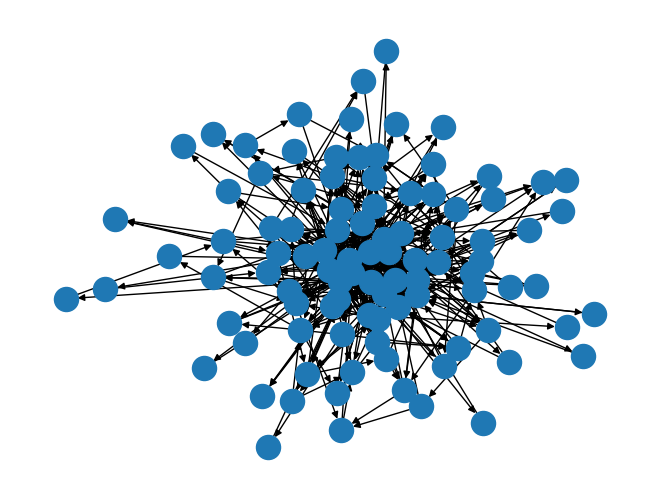

List of Frequent Patterns R4D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 14 		 0.035443037974683546 	 R4 	 D4 	 B3 B1 B8
1 	 3 	 16 		 0.04050632911392405 	 R4 	 D4 	 B3 B1 B6
2 	 2 	 45 		 0.11392405063291139 	 R4 	 D4 	 B3 B1
3 	 2 	 14 		 0.035443037974683546 	 R4 	 D4 	 B1 B8
4 	 2 	 16 		 0.04050632911392405 	 R4 	 D4 	 B1 B6


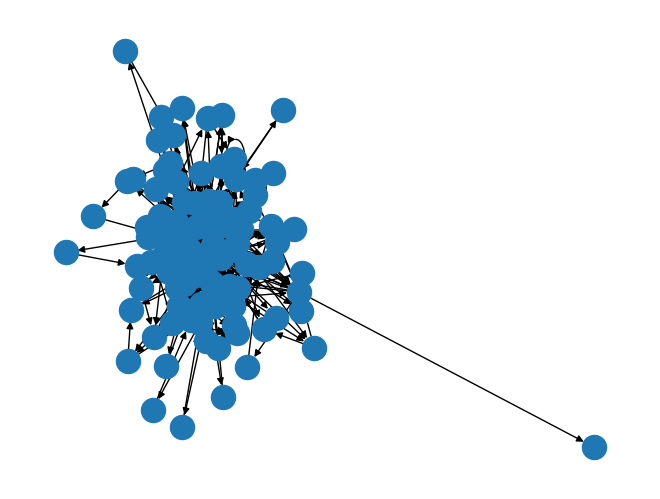

List of Frequent Patterns R4D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 13 		 0.03367875647668394 	 R4 	 D5 	 B3 B1 B8
1 	 3 	 16 		 0.04145077720207254 	 R4 	 D5 	 B3 B1 B6
2 	 2 	 13 		 0.03367875647668394 	 R4 	 D5 	 B1 B8
3 	 2 	 16 		 0.04145077720207254 	 R4 	 D5 	 B1 B6
4 	 2 	 52 		 0.13471502590673576 	 R4 	 D5 	 B3 B1


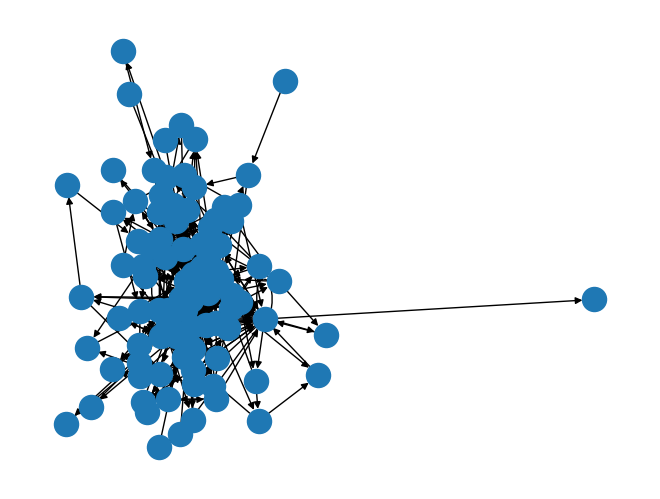

List of Frequent Patterns R4D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 17 		 0.053125 	 R4 	 D6 	 B3 B1 B8
1 	 3 	 14 		 0.04375 	 R4 	 D6 	 B3 B1 B6
2 	 2 	 17 		 0.053125 	 R4 	 D6 	 B1 B8
3 	 2 	 14 		 0.04375 	 R4 	 D6 	 B1 B6
4 	 2 	 39 		 0.121875 	 R4 	 D6 	 B3 B1


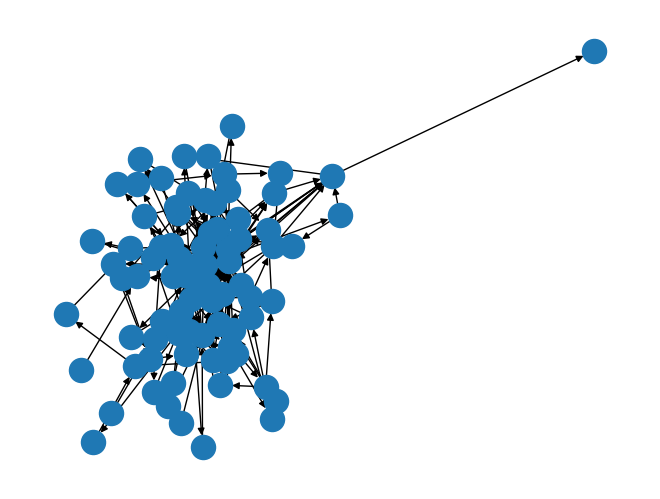

List of Frequent Patterns R4D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 22 		 0.16923076923076924 	 R4 	 D7 	 B3 B1


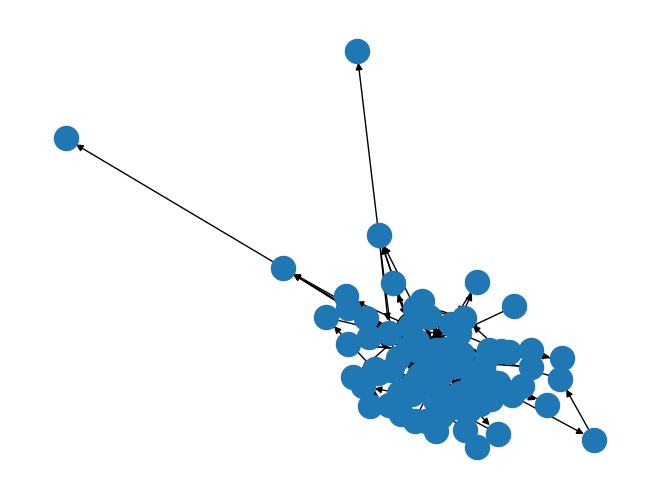

List of Frequent Patterns R4D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 7 		 0.03977272727272727 	 R4 	 D8 	 B3 B1 B6
1 	 3 	 7 		 0.03977272727272727 	 R4 	 D8 	 B3 B1 B8
2 	 2 	 7 		 0.03977272727272727 	 R4 	 D8 	 B1 B6
3 	 2 	 7 		 0.03977272727272727 	 R4 	 D8 	 B1 B8
4 	 2 	 28 		 0.1590909090909091 	 R4 	 D8 	 B3 B1


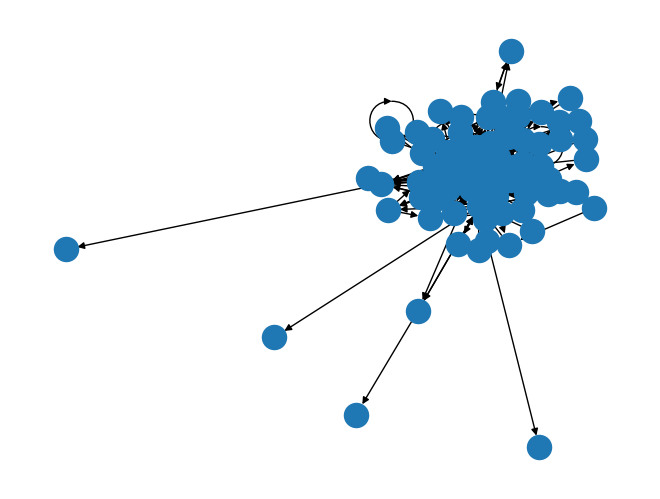

List of Frequent Patterns R4D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 6 		 0.03821656050955414 	 R4 	 D9 	 B1 B6


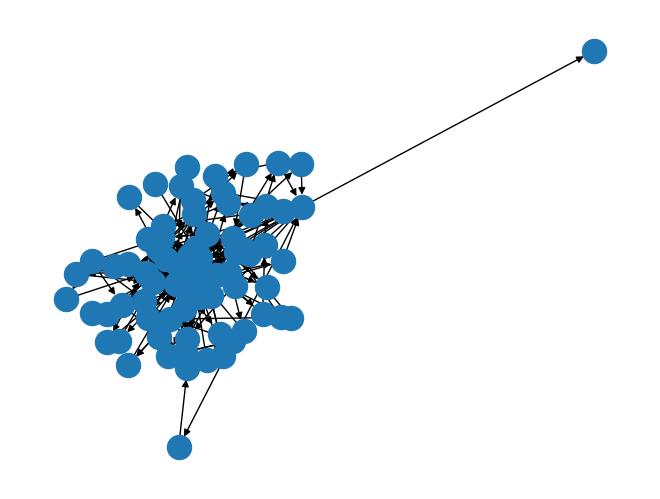

List of Frequent Patterns R4D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 12 		 0.10084033613445378 	 R4 	 D10 	 B1 B6


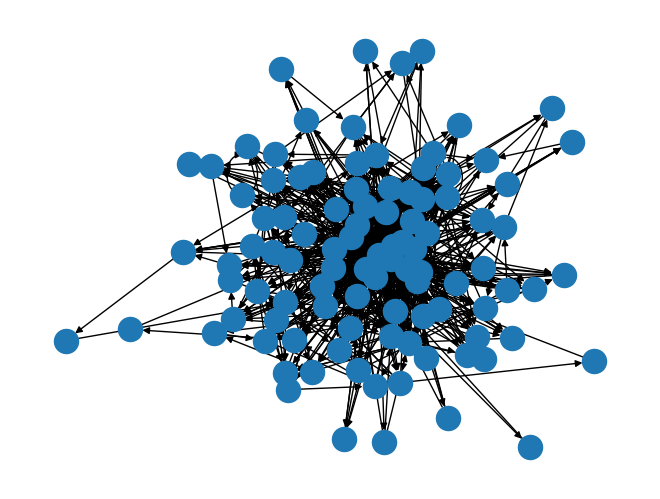

List of Frequent Patterns R5D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 4 	 29 		 0.028019323671497585 	 R5 	 D1 	 B7 B2 B5 B9
1 	 4 	 24 		 0.02318840579710145 	 R5 	 D1 	 B7 B2 B5 B10
2 	 4 	 37 		 0.035748792270531404 	 R5 	 D1 	 B20 B3 B1 B6
3 	 4 	 22 		 0.021256038647342997 	 R5 	 D1 	 B20 B3 B1 B8
4 	 4 	 13 		 0.012560386473429951 	 R5 	 D1 	 B20 B3 B1 B21
5 	 4 	 37 		 0.035748792270531404 	 R5 	 D1 	 B17 B3 B1 B6
6 	 4 	 22 		 0.021256038647342997 	 R5 	 D1 	 B17 B3 B1 B8
7 	 4 	 13 		 0.012560386473429951 	 R5 	 D1 	 B17 B3 B1 B21
8 	 3 	 36 		 0.034782608695652174 	 R5 	 D1 	 B7 B2 B5
9 	 3 	 29 		 0.028019323671497585 	 R5 	 D1 	 B7 B2 B9
10 	 3 	 24 		 0.02318840579710145 	 R5 	 D1 	 B7 B2 B10
11 	 3 	 29 		 0.028019323671497585 	 R5 	 D1 	 B2 B5 B9
12 	 3 	 24 		 0.02318840579710145 	 R5 	 D1 	 B2 B5 B10
13 	 3 	 37 		 0.035748792270531404 	 R5 	 D1 	 B20 B1 B6
14 	 3 	 22 		 0.021256038647342997 	 R5 	 D1 	 B20 B1 B8
15 	 3 	 13 		 0.0125603864734299

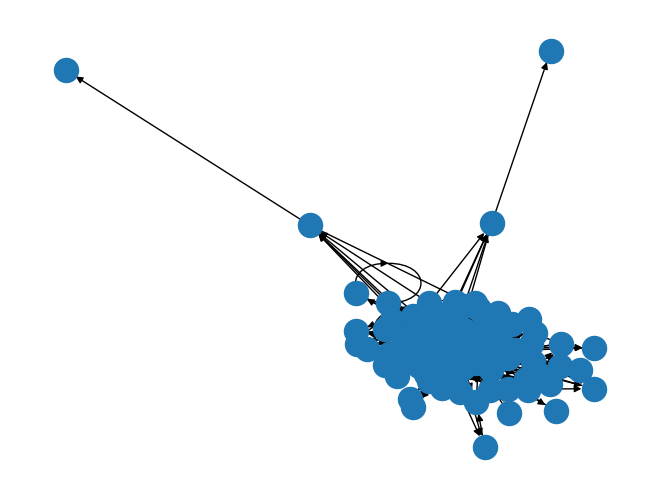

List of Frequent Patterns R5D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 19 		 0.03368794326241135 	 R5 	 D2 	 B3 B1 B8
1 	 3 	 23 		 0.040780141843971635 	 R5 	 D2 	 B3 B1 B6
2 	 2 	 19 		 0.03368794326241135 	 R5 	 D2 	 B1 B8
3 	 2 	 23 		 0.040780141843971635 	 R5 	 D2 	 B1 B6
4 	 2 	 26 		 0.04609929078014184 	 R5 	 D2 	 B2 B7
5 	 2 	 19 		 0.03368794326241135 	 R5 	 D2 	 B2 B5
6 	 2 	 61 		 0.10815602836879433 	 R5 	 D2 	 B3 B1


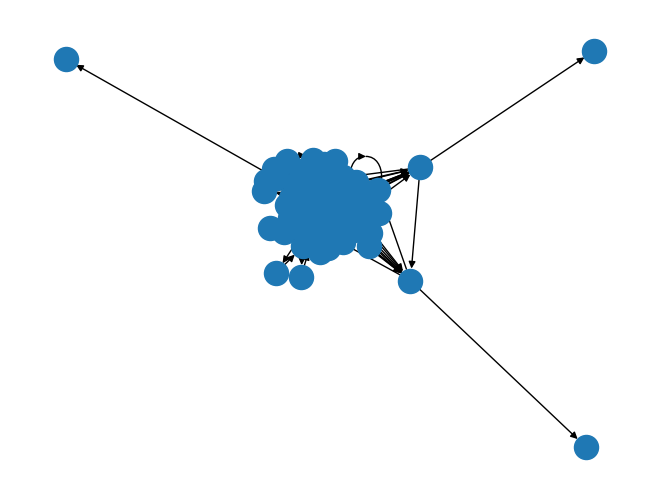

List of Frequent Patterns R5D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 13 		 0.031862745098039214 	 R5 	 D3 	 B2 B5 B14
1 	 3 	 15 		 0.03676470588235294 	 R5 	 D3 	 B47 B1 B6
2 	 3 	 15 		 0.03676470588235294 	 R5 	 D3 	 B3 B1 B6
3 	 2 	 19 		 0.04656862745098039 	 R5 	 D3 	 B2 B5
4 	 2 	 13 		 0.031862745098039214 	 R5 	 D3 	 B5 B14
5 	 2 	 15 		 0.03676470588235294 	 R5 	 D3 	 B1 B6
6 	 2 	 52 		 0.12745098039215685 	 R5 	 D3 	 B47 B1
7 	 2 	 52 		 0.12745098039215685 	 R5 	 D3 	 B3 B1


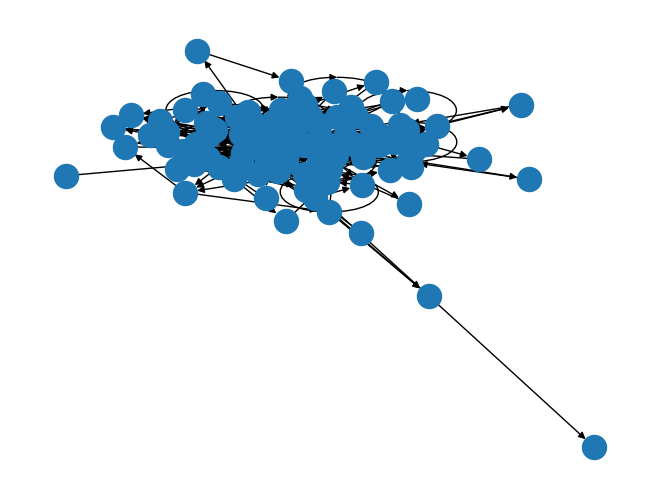

List of Frequent Patterns R5D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 14 		 0.05128205128205128 	 R5 	 D4 	 B3 B1 B6
1 	 2 	 36 		 0.13186813186813187 	 R5 	 D4 	 B3 B1
2 	 2 	 14 		 0.05128205128205128 	 R5 	 D4 	 B1 B6


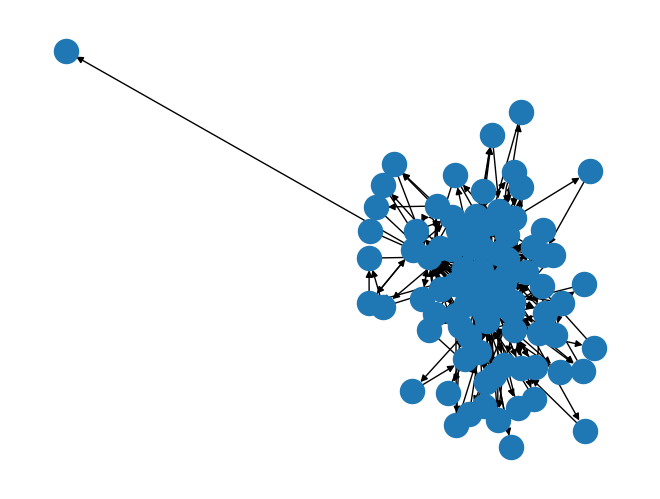

List of Frequent Patterns R5D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 12 		 0.05263157894736842 	 R5 	 D5 	 B3 B1 B6
1 	 3 	 5 		 0.021929824561403508 	 R5 	 D5 	 B3 B1 B21
2 	 2 	 29 		 0.12719298245614036 	 R5 	 D5 	 B3 B1
3 	 2 	 12 		 0.05263157894736842 	 R5 	 D5 	 B1 B6
4 	 2 	 5 		 0.021929824561403508 	 R5 	 D5 	 B1 B21


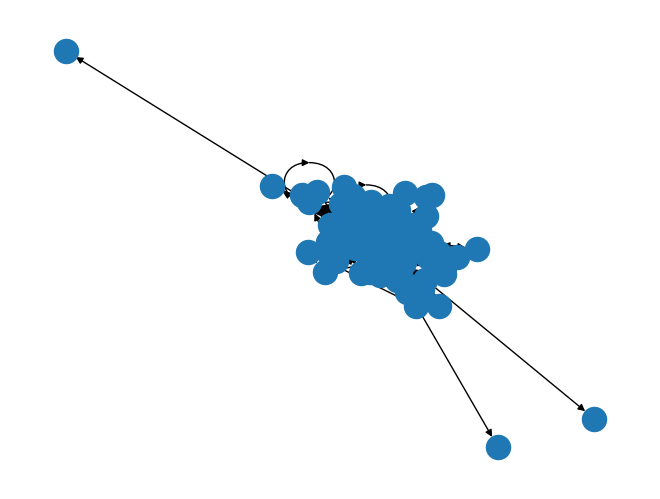

List of Frequent Patterns R5D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 9 		 0.04411764705882353 	 R5 	 D6 	 B3 B1 B8
1 	 2 	 27 		 0.1323529411764706 	 R5 	 D6 	 B3 B1
2 	 2 	 9 		 0.04411764705882353 	 R5 	 D6 	 B1 B8


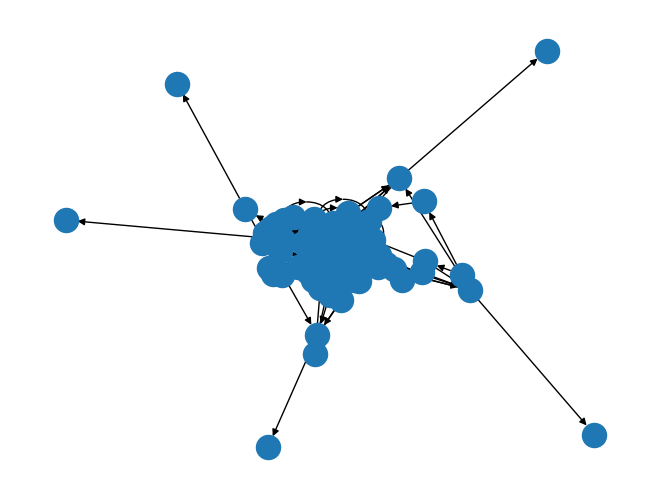

List of Frequent Patterns R5D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


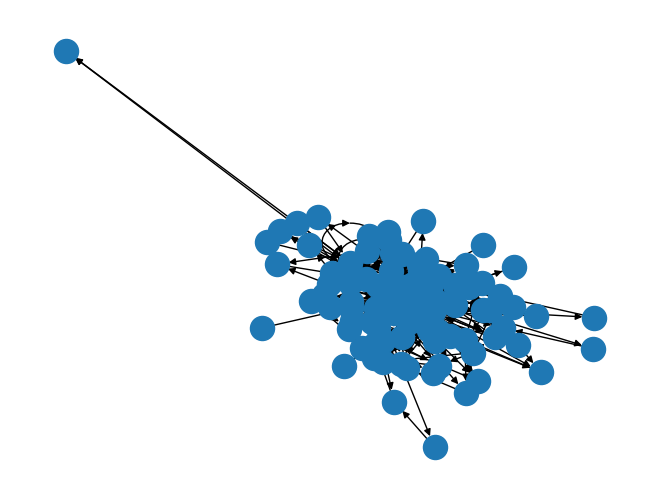

List of Frequent Patterns R5D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 22 		 0.12290502793296089 	 R5 	 D8 	 B23 B3


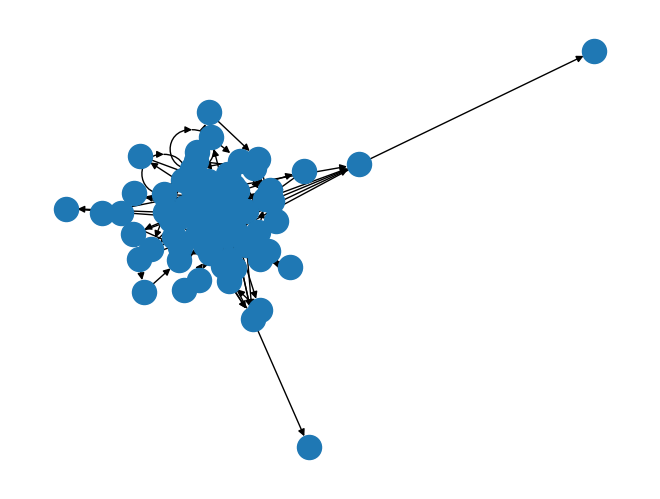

List of Frequent Patterns R5D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 21 		 0.19090909090909092 	 R5 	 D9 	 B3 B1


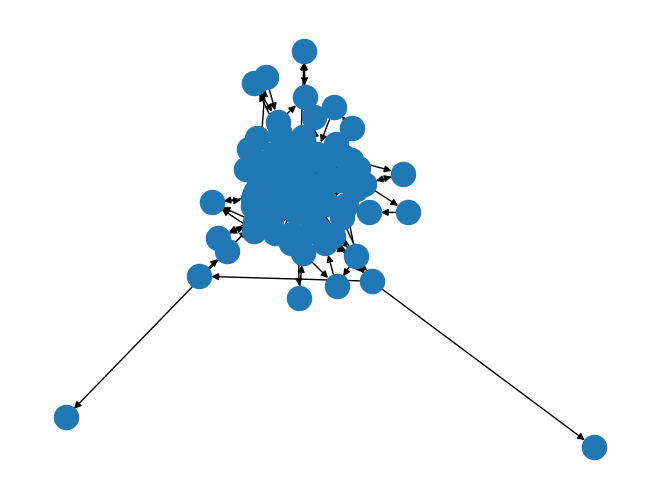

List of Frequent Patterns R5D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 7 		 0.05982905982905983 	 R5 	 D10 	 B1 B8
1 	 2 	 12 		 0.10256410256410256 	 R5 	 D10 	 B2 B5


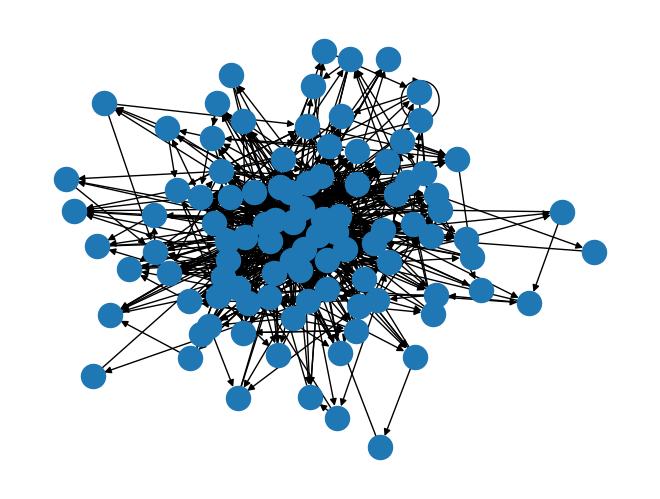

List of Frequent Patterns R6D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 4 	 34 		 0.03859250851305335 	 R6 	 D1 	 B17 B3 B1 B6
1 	 4 	 26 		 0.029511918274687854 	 R6 	 D1 	 B17 B3 B1 B8
2 	 4 	 9 		 0.01021566401816118 	 R6 	 D1 	 B17 B3 B1 B48
3 	 4 	 9 		 0.01021566401816118 	 R6 	 D1 	 B17 B3 B1 B28
4 	 3 	 18 		 0.02043132803632236 	 R6 	 D1 	 B2 B5 B10
5 	 3 	 34 		 0.03859250851305335 	 R6 	 D1 	 B3 B1 B6
6 	 3 	 26 		 0.029511918274687854 	 R6 	 D1 	 B3 B1 B8
7 	 3 	 9 		 0.01021566401816118 	 R6 	 D1 	 B3 B1 B48
8 	 3 	 9 		 0.01021566401816118 	 R6 	 D1 	 B3 B1 B28
9 	 3 	 84 		 0.09534619750283768 	 R6 	 D1 	 B17 B3 B1
10 	 2 	 18 		 0.02043132803632236 	 R6 	 D1 	 B4 B12
11 	 2 	 32 		 0.036322360953461974 	 R6 	 D1 	 B2 B5
12 	 2 	 18 		 0.02043132803632236 	 R6 	 D1 	 B2 B10
13 	 2 	 34 		 0.03859250851305335 	 R6 	 D1 	 B1 B6
14 	 2 	 26 		 0.029511918274687854 	 R6 	 D1 	 B1 B8
15 	 2 	 9 		 0.01021566401816118 	 R6 	 D1 	 B1 B48
16 	 2 	 9 		 0.0102

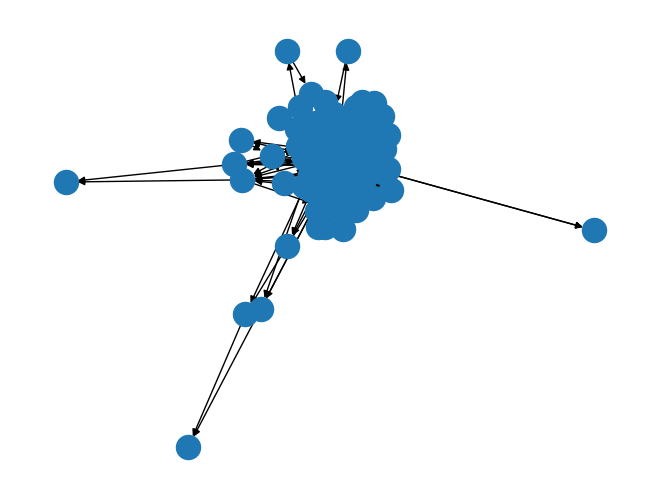

List of Frequent Patterns R6D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 12 		 0.030226700251889168 	 R6 	 D2 	 B3 B1 B13
1 	 3 	 13 		 0.0327455919395466 	 R6 	 D2 	 B3 B1 B6
2 	 2 	 12 		 0.030226700251889168 	 R6 	 D2 	 B1 B13
3 	 2 	 13 		 0.0327455919395466 	 R6 	 D2 	 B1 B6
4 	 2 	 18 		 0.04534005037783375 	 R6 	 D2 	 B2 B5
5 	 2 	 53 		 0.13350125944584382 	 R6 	 D2 	 B3 B1


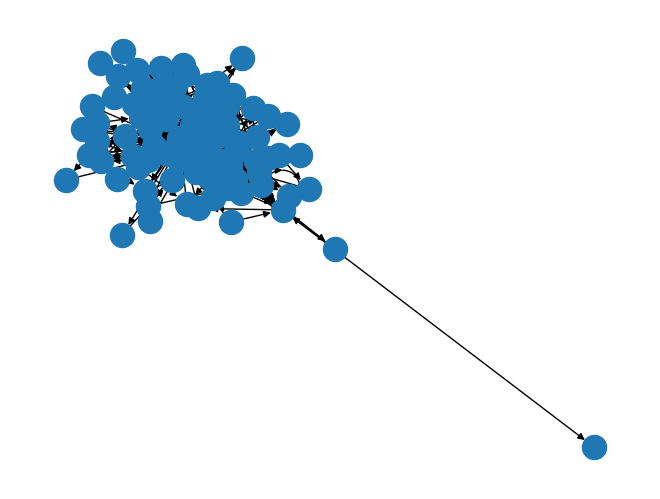

List of Frequent Patterns R6D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 38 		 0.10584958217270195 	 R6 	 D3 	 B29 B1
1 	 2 	 38 		 0.10584958217270195 	 R6 	 D3 	 B3 B1


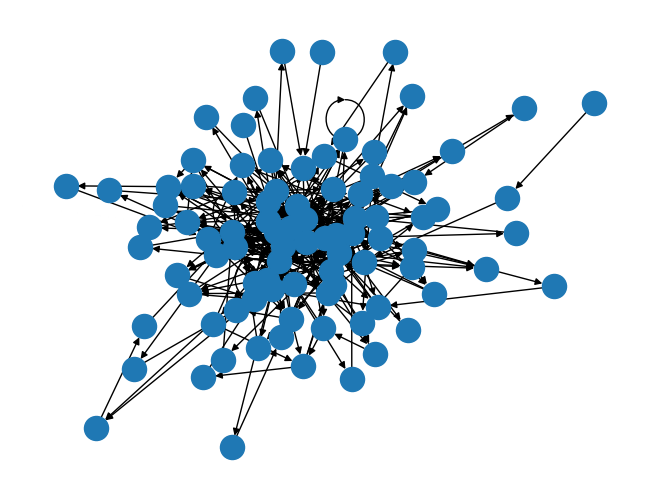

List of Frequent Patterns R6D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 11 		 0.049107142857142856 	 R6 	 D4 	 B3 B1 B8
1 	 2 	 11 		 0.049107142857142856 	 R6 	 D4 	 B1 B8
2 	 2 	 35 		 0.15625 	 R6 	 D4 	 B3 B1
3 	 2 	 13 		 0.05803571428571429 	 R6 	 D4 	 B2 B5


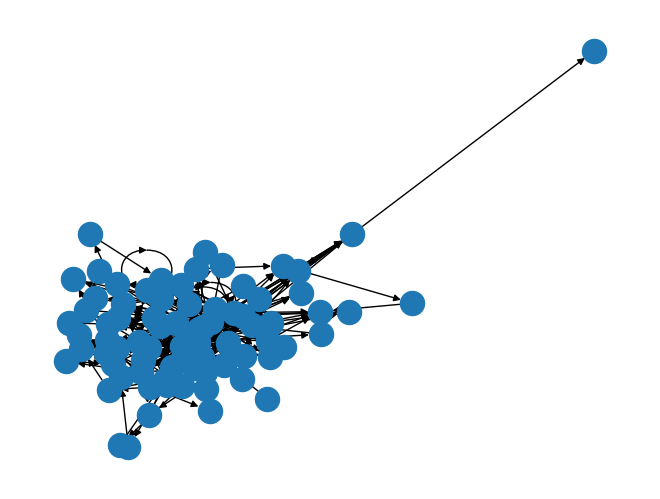

List of Frequent Patterns R6D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 14 		 0.06542056074766354 	 R6 	 D5 	 B1 B8
1 	 2 	 9 		 0.04205607476635514 	 R6 	 D5 	 B2 B5


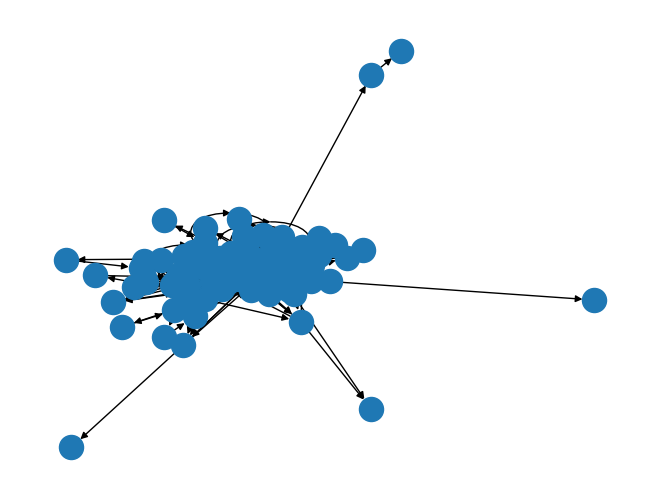

List of Frequent Patterns R6D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 8 		 0.0392156862745098 	 R6 	 D6 	 B3 B1 B8
1 	 2 	 8 		 0.0392156862745098 	 R6 	 D6 	 B1 B8
2 	 2 	 14 		 0.06862745098039216 	 R6 	 D6 	 B2 B5
3 	 2 	 35 		 0.1715686274509804 	 R6 	 D6 	 B3 B1


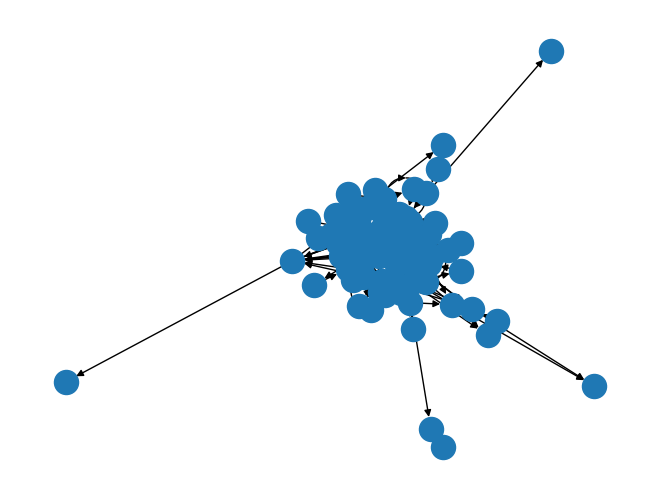

List of Frequent Patterns R6D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 7 		 0.056910569105691054 	 R6 	 D7 	 B3 B1 B6
1 	 2 	 7 		 0.056910569105691054 	 R6 	 D7 	 B1 B6
2 	 2 	 22 		 0.17886178861788618 	 R6 	 D7 	 B3 B1


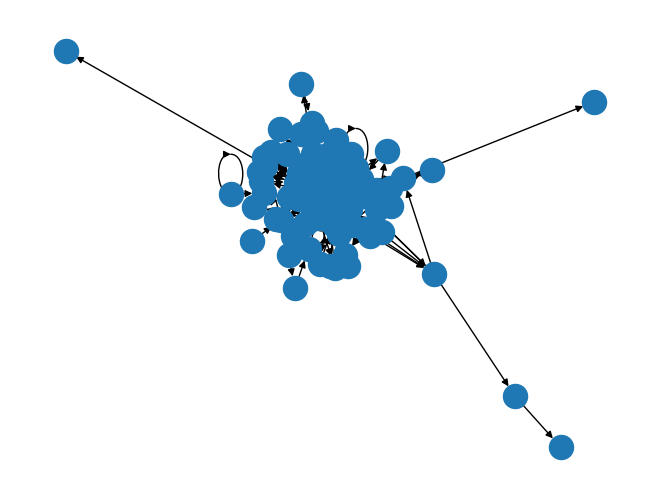

List of Frequent Patterns R6D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 27 		 0.15606936416184972 	 R6 	 D8 	 B3 B1


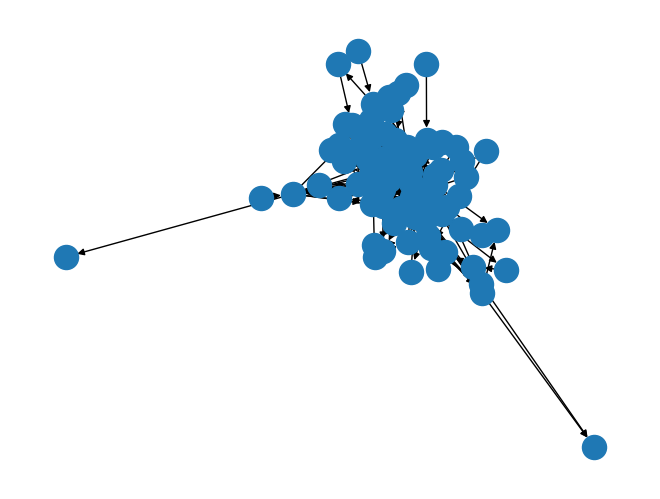

List of Frequent Patterns R6D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


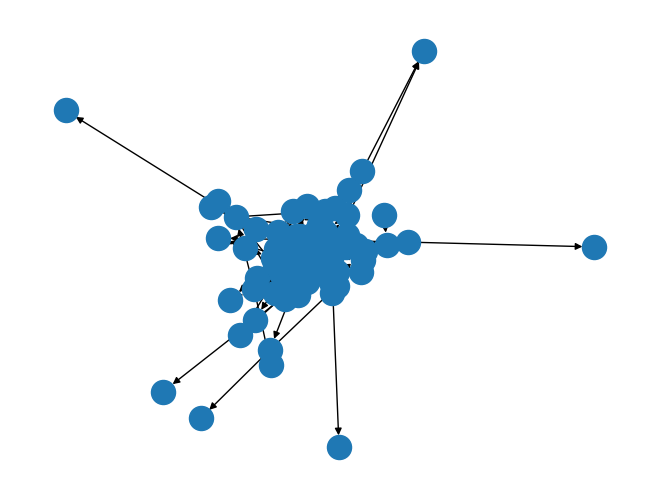

List of Frequent Patterns R6D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 12 		 0.11764705882352941 	 R6 	 D10 	 B2 B5
1 	 2 	 20 		 0.19607843137254902 	 R6 	 D10 	 B3 B1


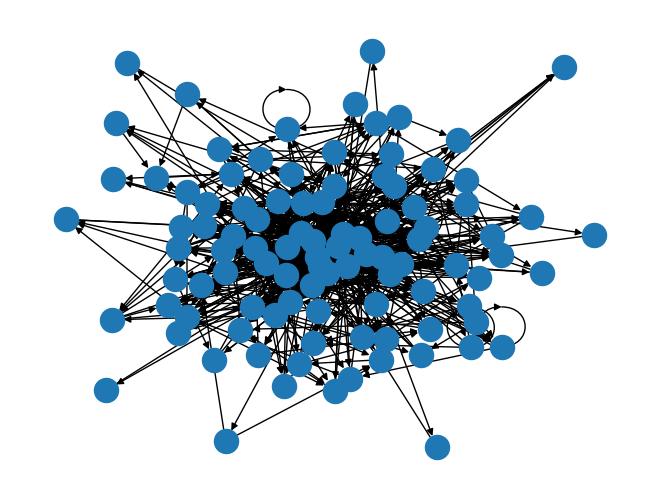

List of Frequent Patterns R7D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 5 	 14 		 0.016 	 R7 	 D1 	 B24 B3 B1 B4 B22
1 	 5 	 28 		 0.032 	 R7 	 D1 	 B24 B3 B1 B8 B6
2 	 4 	 14 		 0.016 	 R7 	 D1 	 B20 B1 B4 B22
3 	 4 	 28 		 0.032 	 R7 	 D1 	 B20 B1 B8 B6
4 	 4 	 14 		 0.016 	 R7 	 D1 	 B3 B1 B4 B22
5 	 4 	 28 		 0.032 	 R7 	 D1 	 B3 B1 B8 B6
6 	 4 	 14 		 0.016 	 R7 	 D1 	 B24 B1 B4 B22
7 	 4 	 28 		 0.032 	 R7 	 D1 	 B24 B1 B8 B6
8 	 4 	 20 		 0.022857142857142857 	 R7 	 D1 	 B24 B3 B1 B18
9 	 4 	 36 		 0.04114285714285714 	 R7 	 D1 	 B24 B3 B1 B4
10 	 4 	 28 		 0.032 	 R7 	 D1 	 B24 B3 B1 B6
11 	 4 	 7 		 0.008 	 R7 	 D1 	 B24 B3 B1 B21
12 	 4 	 21 		 0.024 	 R7 	 D1 	 B24 B3 B1 B8
13 	 4 	 14 		 0.016 	 R7 	 D1 	 B47 B1 B4 B22
14 	 4 	 28 		 0.032 	 R7 	 D1 	 B47 B1 B8 B6
15 	 3 	 20 		 0.022857142857142857 	 R7 	 D1 	 B20 B1 B18
16 	 3 	 36 		 0.04114285714285714 	 R7 	 D1 	 B20 B1 B4
17 	 3 	 28 		 0.032 	 R7 	 D1 	 B20 B1 B6
18 	 3 	 7 		 0.008 	 R7 	 D1 	 B2

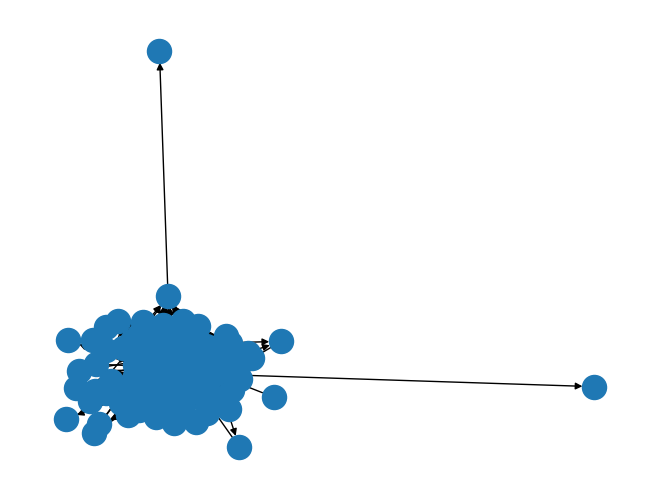

List of Frequent Patterns R7D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 18 		 0.04904632152588556 	 R7 	 D2 	 B3 B1 B6
1 	 2 	 18 		 0.04904632152588556 	 R7 	 D2 	 B2 B9
2 	 2 	 18 		 0.04904632152588556 	 R7 	 D2 	 B1 B6
3 	 2 	 43 		 0.11716621253405994 	 R7 	 D2 	 B3 B1


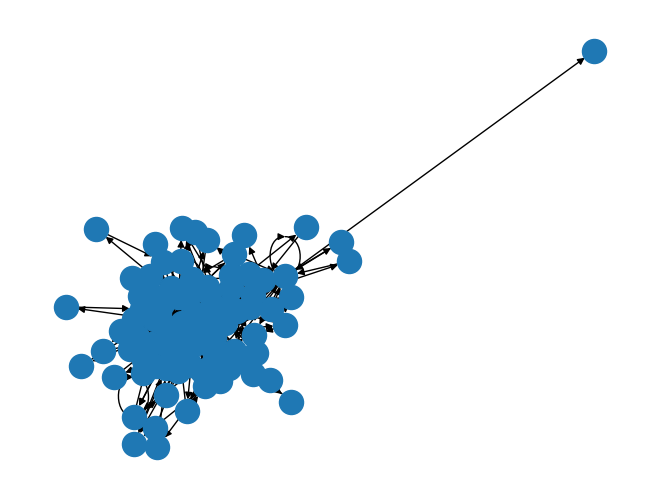

List of Frequent Patterns R7D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 12 		 0.04013377926421405 	 R7 	 D3 	 B3 B1 B8
1 	 3 	 18 		 0.06020066889632107 	 R7 	 D3 	 B3 B1 B6
2 	 3 	 12 		 0.04013377926421405 	 R7 	 D3 	 B20 B1 B8
3 	 3 	 18 		 0.06020066889632107 	 R7 	 D3 	 B20 B1 B6
4 	 2 	 41 		 0.13712374581939799 	 R7 	 D3 	 B3 B1
5 	 2 	 12 		 0.04013377926421405 	 R7 	 D3 	 B1 B8
6 	 2 	 18 		 0.06020066889632107 	 R7 	 D3 	 B1 B6
7 	 2 	 41 		 0.13712374581939799 	 R7 	 D3 	 B20 B1


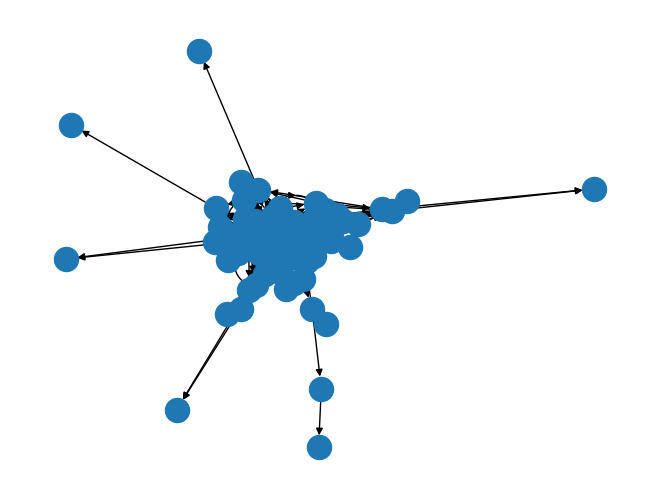

List of Frequent Patterns R7D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 19 		 0.08225108225108226 	 R7 	 D4 	 B3 B1 B6
1 	 2 	 32 		 0.13852813852813853 	 R7 	 D4 	 B3 B1
2 	 2 	 19 		 0.08225108225108226 	 R7 	 D4 	 B1 B6


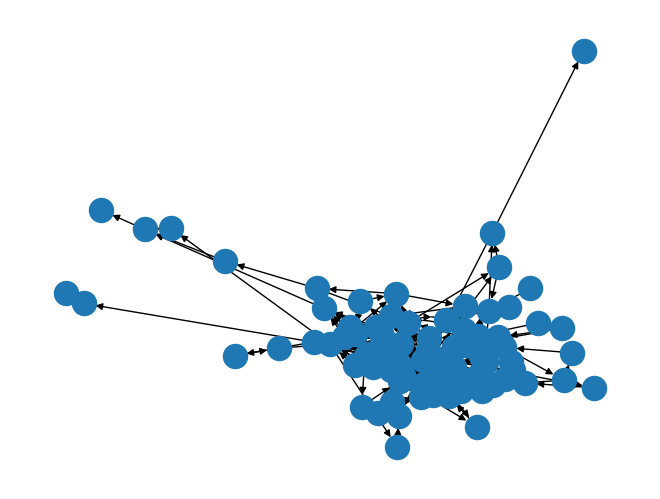

List of Frequent Patterns R7D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


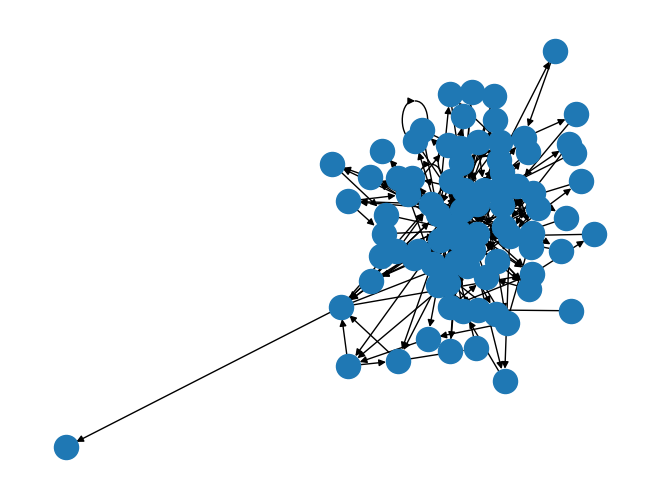

List of Frequent Patterns R7D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 9 		 0.059602649006622516 	 R7 	 D6 	 B3 B1 B8
1 	 2 	 9 		 0.059602649006622516 	 R7 	 D6 	 B1 B8
2 	 2 	 23 		 0.152317880794702 	 R7 	 D6 	 B3 B1


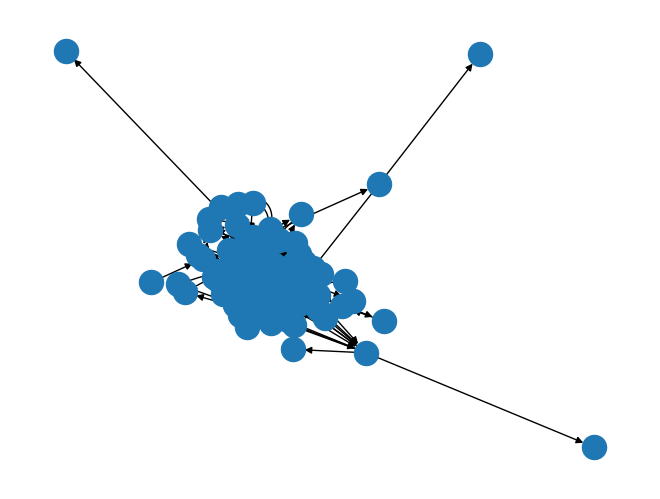

List of Frequent Patterns R7D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 8 		 0.048484848484848485 	 R7 	 D7 	 B3 B1 B8
1 	 2 	 8 		 0.048484848484848485 	 R7 	 D7 	 B1 B8
2 	 2 	 26 		 0.15757575757575756 	 R7 	 D7 	 B3 B1


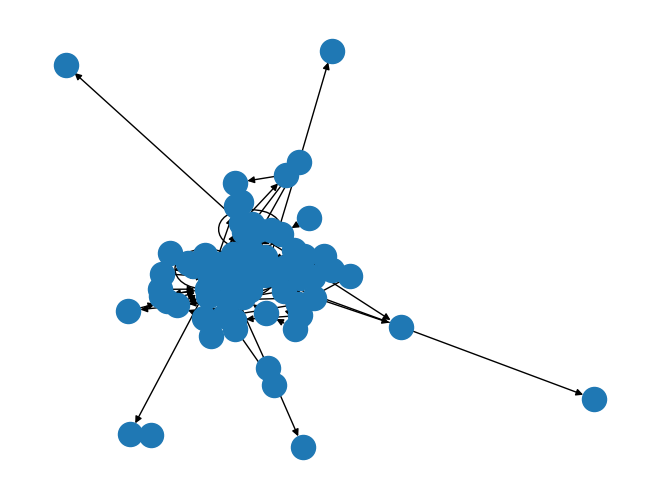

List of Frequent Patterns R7D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


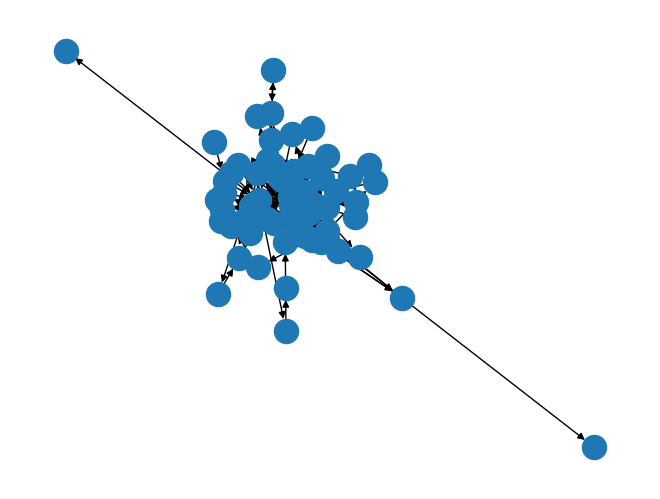

List of Frequent Patterns R7D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


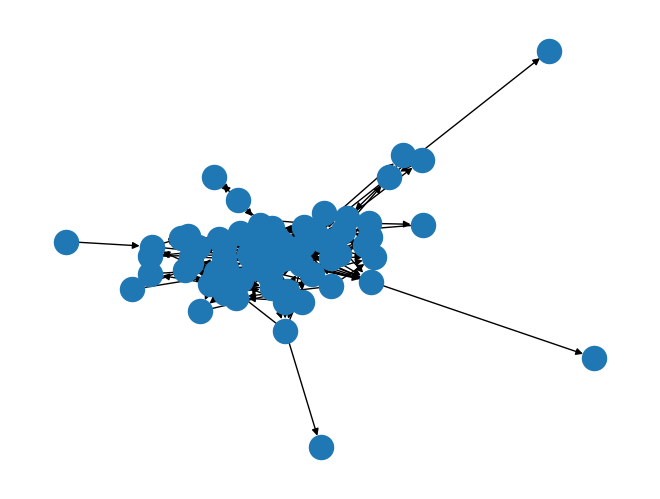

List of Frequent Patterns R7D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


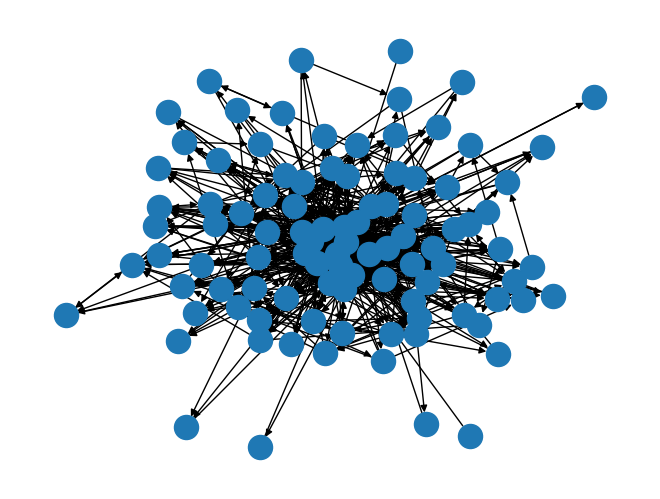

List of Frequent Patterns R8D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 26 		 0.03407601572739188 	 R8 	 D1 	 B2 B7 B10
1 	 3 	 21 		 0.027522935779816515 	 R8 	 D1 	 B3 B1 B8
2 	 3 	 26 		 0.03407601572739188 	 R8 	 D1 	 B3 B1 B6
3 	 3 	 14 		 0.01834862385321101 	 R8 	 D1 	 B3 B1 B13
4 	 3 	 21 		 0.027522935779816515 	 R8 	 D1 	 B71 B1 B8
5 	 3 	 26 		 0.03407601572739188 	 R8 	 D1 	 B71 B1 B6
6 	 3 	 14 		 0.01834862385321101 	 R8 	 D1 	 B71 B1 B13
7 	 2 	 21 		 0.027522935779816515 	 R8 	 D1 	 B1 B8
8 	 2 	 26 		 0.03407601572739188 	 R8 	 D1 	 B1 B6
9 	 2 	 14 		 0.01834862385321101 	 R8 	 D1 	 B1 B13
10 	 2 	 26 		 0.03407601572739188 	 R8 	 D1 	 B2 B5
11 	 2 	 28 		 0.03669724770642202 	 R8 	 D1 	 B2 B7
12 	 2 	 26 		 0.03407601572739188 	 R8 	 D1 	 B2 B10
13 	 2 	 67 		 0.08781127129750983 	 R8 	 D1 	 B3 B1
14 	 2 	 26 		 0.03407601572739188 	 R8 	 D1 	 B7 B10
15 	 2 	 67 		 0.08781127129750983 	 R8 	 D1 	 B71 B1


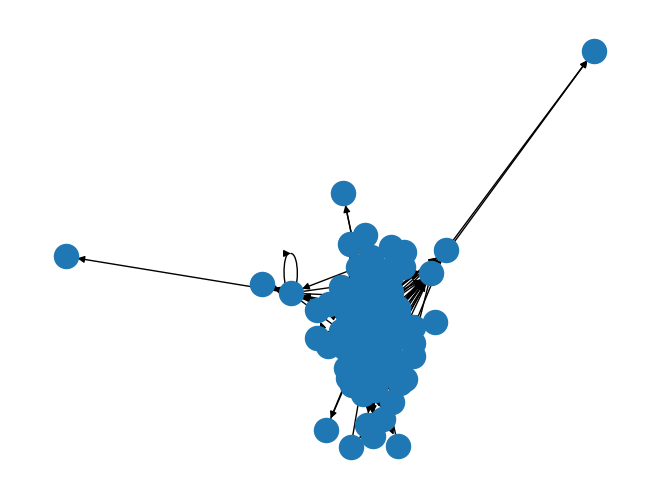

List of Frequent Patterns R8D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 26 		 0.04980842911877394 	 R8 	 D2 	 B3 B1 B6
1 	 3 	 15 		 0.028735632183908046 	 R8 	 D2 	 B3 B1 B8
2 	 3 	 17 		 0.032567049808429116 	 R8 	 D2 	 B2 B5 B14
3 	 2 	 26 		 0.04980842911877394 	 R8 	 D2 	 B1 B6
4 	 2 	 15 		 0.028735632183908046 	 R8 	 D2 	 B1 B8
5 	 2 	 53 		 0.10153256704980843 	 R8 	 D2 	 B3 B1
6 	 2 	 17 		 0.032567049808429116 	 R8 	 D2 	 B5 B14
7 	 2 	 28 		 0.05363984674329502 	 R8 	 D2 	 B2 B5


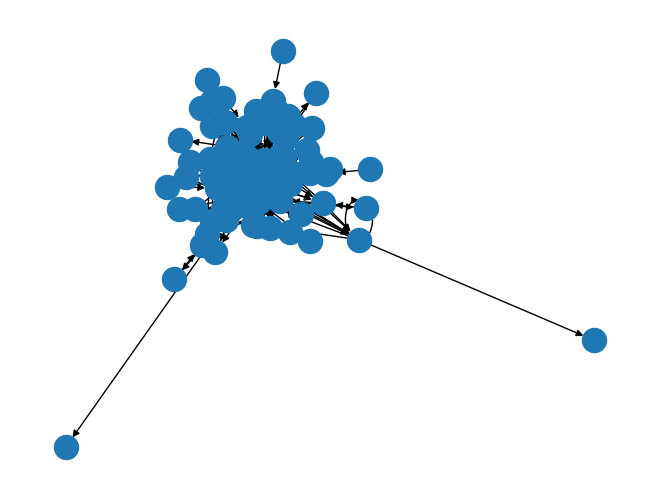

List of Frequent Patterns R8D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 13 		 0.06435643564356436 	 R8 	 D3 	 B1 B8


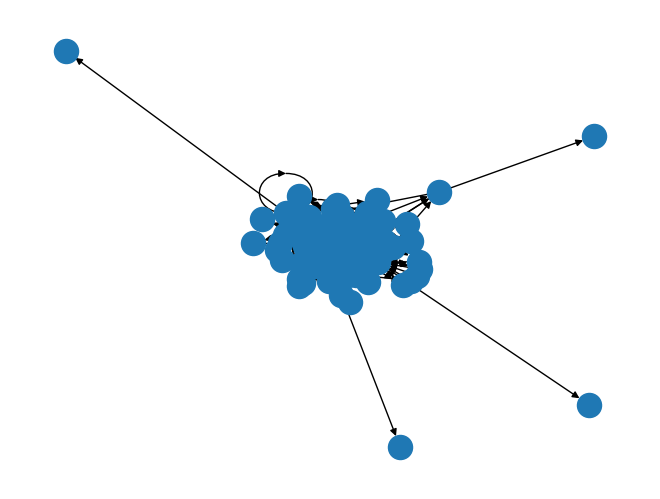

List of Frequent Patterns R8D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 11 		 0.04954954954954955 	 R8 	 D4 	 B3 B1 B8
1 	 2 	 11 		 0.04954954954954955 	 R8 	 D4 	 B1 B8
2 	 2 	 34 		 0.15315315315315314 	 R8 	 D4 	 B3 B1


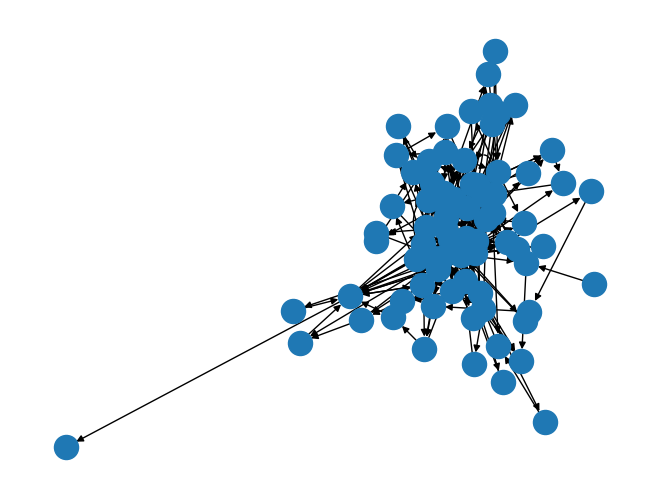

List of Frequent Patterns R8D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


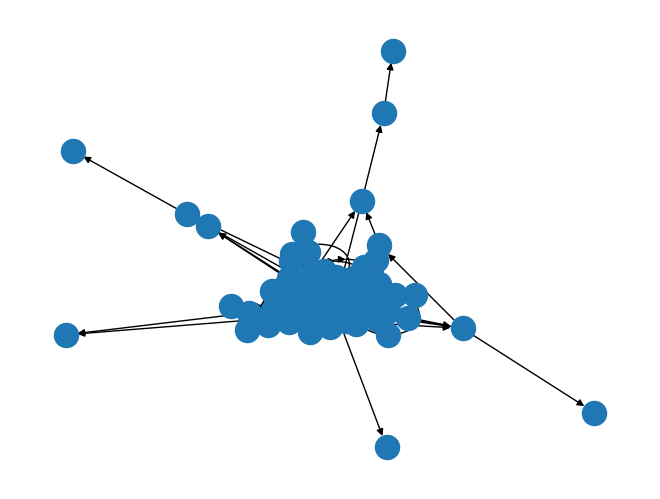

List of Frequent Patterns R8D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 11 		 0.05238095238095238 	 R8 	 D6 	 B3 B1 B8
1 	 3 	 12 		 0.05714285714285714 	 R8 	 D6 	 B3 B1 B6
2 	 2 	 34 		 0.1619047619047619 	 R8 	 D6 	 B3 B1
3 	 2 	 11 		 0.05238095238095238 	 R8 	 D6 	 B1 B8
4 	 2 	 12 		 0.05714285714285714 	 R8 	 D6 	 B1 B6


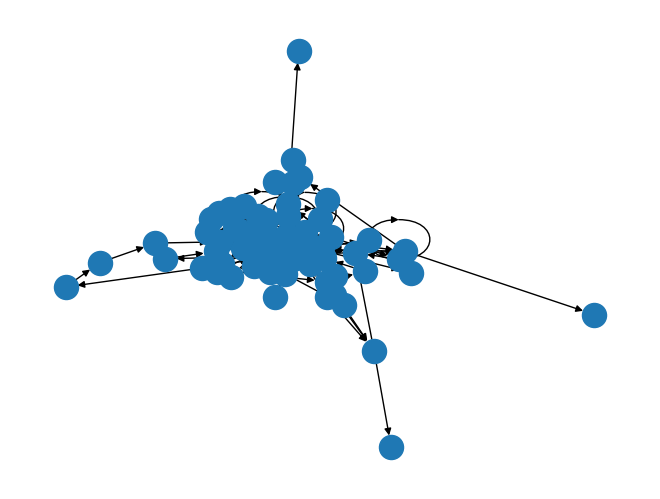

List of Frequent Patterns R8D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


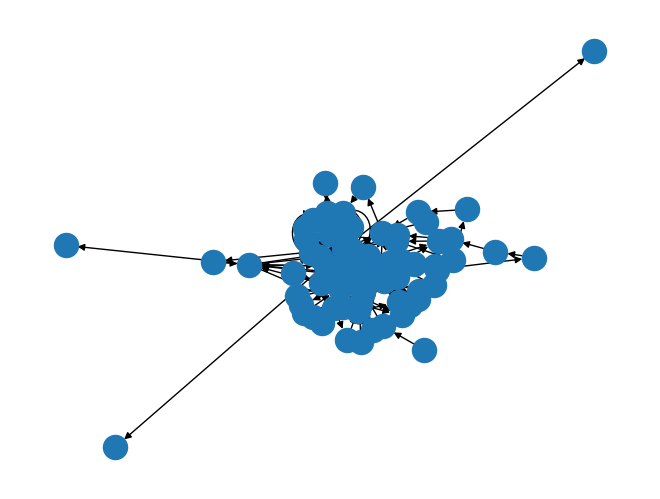

List of Frequent Patterns R8D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


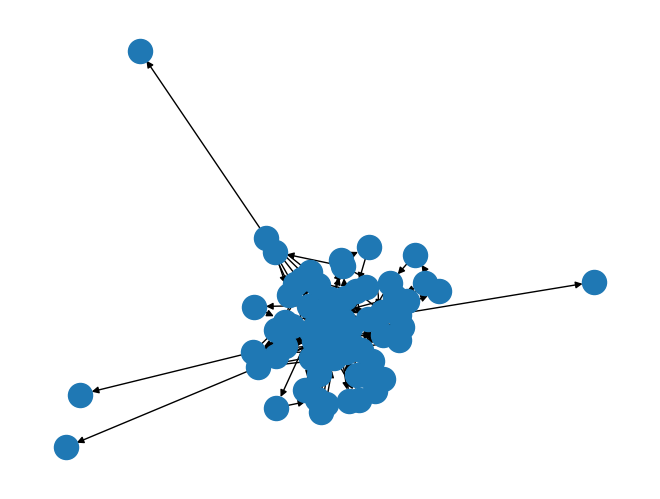

List of Frequent Patterns R8D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 5 		 0.07462686567164178 	 R8 	 D9 	 B1 B8


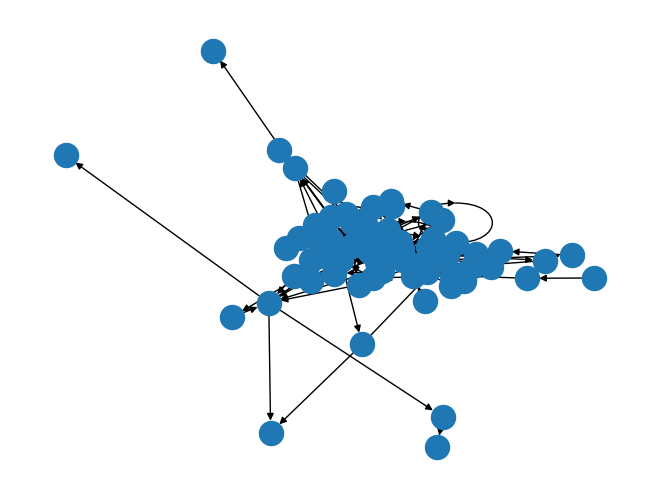

List of Frequent Patterns R8D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


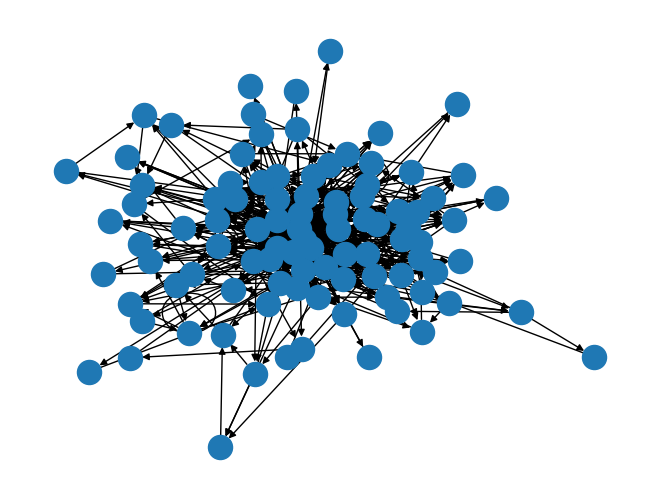

List of Frequent Patterns R9D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 28 		 0.04674457429048414 	 R9 	 D1 	 B3 B1 B8
1 	 3 	 22 		 0.03672787979966611 	 R9 	 D1 	 B3 B1 B6
2 	 3 	 16 		 0.02671118530884808 	 R9 	 D1 	 B2 B5 B10
3 	 2 	 63 		 0.10517529215358931 	 R9 	 D1 	 B3 B1
4 	 2 	 29 		 0.048414023372287146 	 R9 	 D1 	 B2 B5
5 	 2 	 28 		 0.04674457429048414 	 R9 	 D1 	 B1 B8
6 	 2 	 22 		 0.03672787979966611 	 R9 	 D1 	 B1 B6
7 	 2 	 16 		 0.02671118530884808 	 R9 	 D1 	 B5 B10


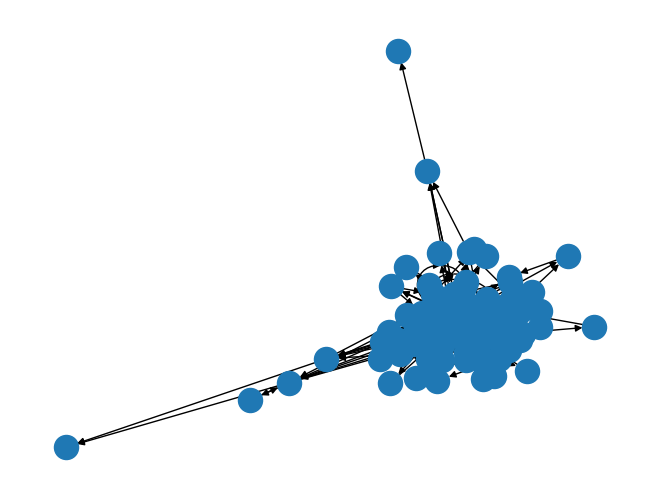

List of Frequent Patterns R9D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 15 		 0.04297994269340974 	 R9 	 D2 	 B3 B1 B6
1 	 3 	 16 		 0.045845272206303724 	 R9 	 D2 	 B3 B1 B8
2 	 2 	 15 		 0.04297994269340974 	 R9 	 D2 	 B1 B6
3 	 2 	 16 		 0.045845272206303724 	 R9 	 D2 	 B1 B8
4 	 2 	 34 		 0.09742120343839542 	 R9 	 D2 	 B3 B1


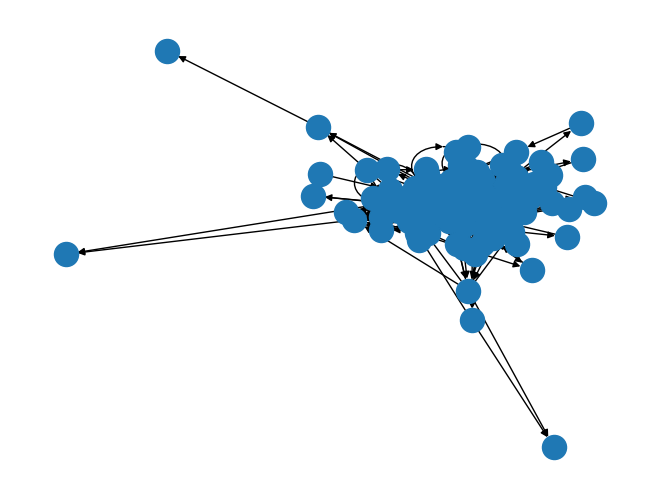

List of Frequent Patterns R9D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 10 		 0.03546099290780142 	 R9 	 D3 	 B3 B1 B8
1 	 3 	 10 		 0.03546099290780142 	 R9 	 D3 	 B35 B1 B8
2 	 2 	 39 		 0.13829787234042554 	 R9 	 D3 	 B3 B1
3 	 2 	 9 		 0.031914893617021274 	 R9 	 D3 	 B2 B5
4 	 2 	 10 		 0.03546099290780142 	 R9 	 D3 	 B1 B8
5 	 2 	 39 		 0.13829787234042554 	 R9 	 D3 	 B35 B1


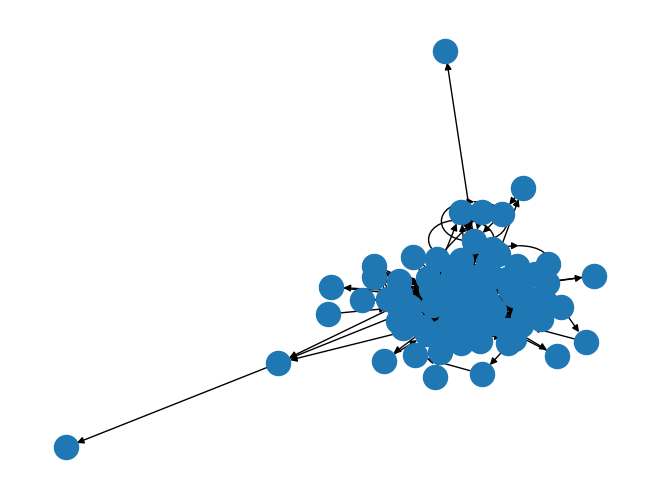

List of Frequent Patterns R9D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 10 		 0.05555555555555555 	 R9 	 D4 	 B2 B5
1 	 2 	 27 		 0.15 	 R9 	 D4 	 B3 B1


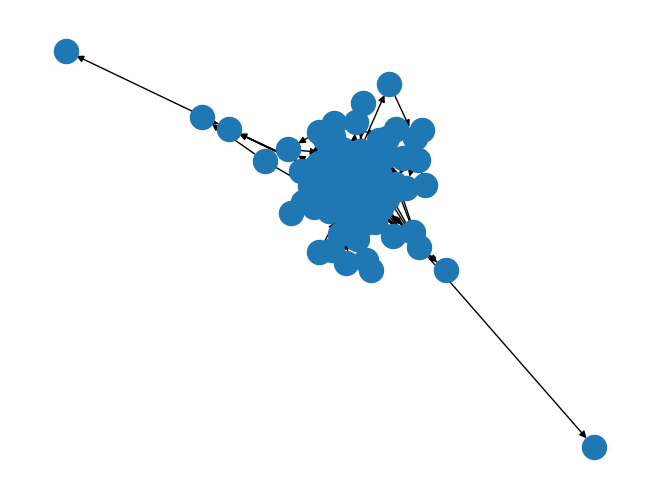

List of Frequent Patterns R9D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 12 		 0.09022556390977443 	 R9 	 D5 	 B3 B1 B8
1 	 2 	 21 		 0.15789473684210525 	 R9 	 D5 	 B3 B1
2 	 2 	 12 		 0.09022556390977443 	 R9 	 D5 	 B1 B8


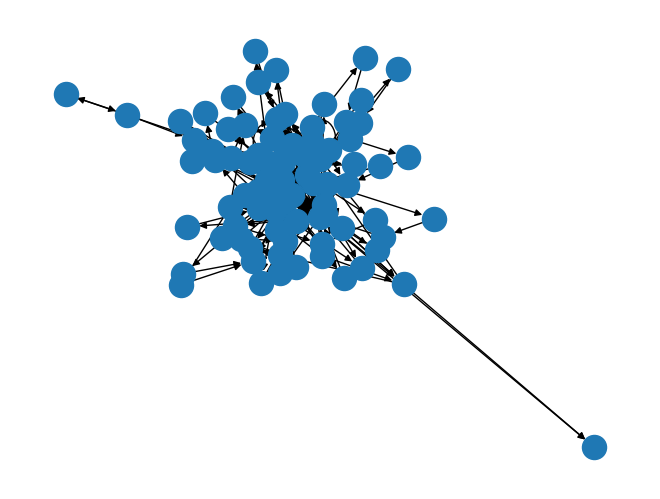

List of Frequent Patterns R9D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 13 		 0.08552631578947369 	 R9 	 D6 	 B3 B1 B6
1 	 2 	 13 		 0.08552631578947369 	 R9 	 D6 	 B1 B6
2 	 2 	 19 		 0.125 	 R9 	 D6 	 B3 B1


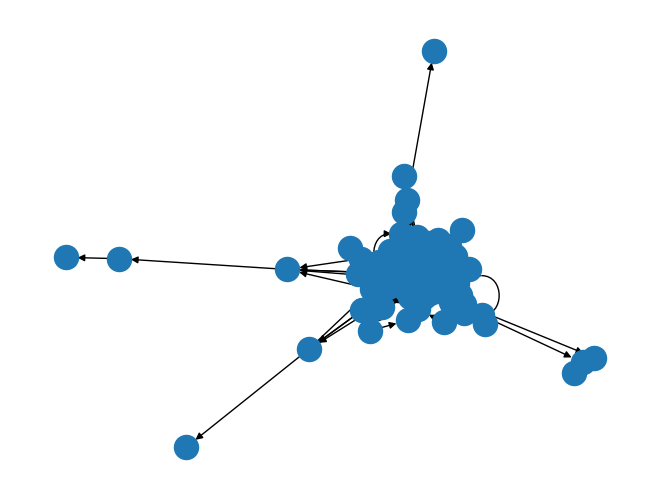

List of Frequent Patterns R9D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


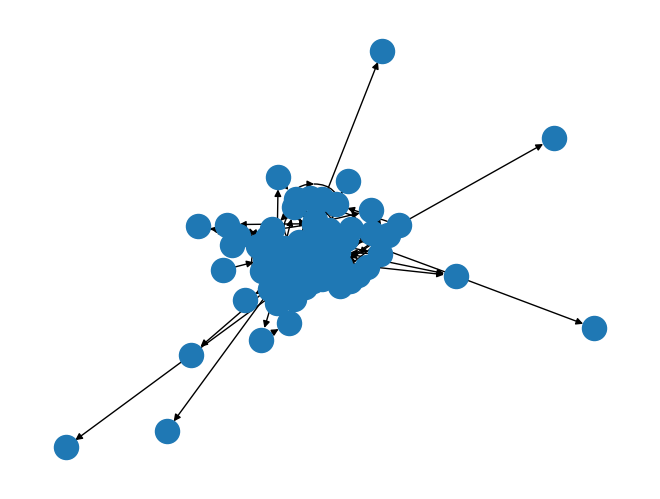

List of Frequent Patterns R9D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 7 		 0.08235294117647059 	 R9 	 D8 	 B3 B1 B6
1 	 2 	 18 		 0.21176470588235294 	 R9 	 D8 	 B3 B1
2 	 2 	 7 		 0.08235294117647059 	 R9 	 D8 	 B1 B6


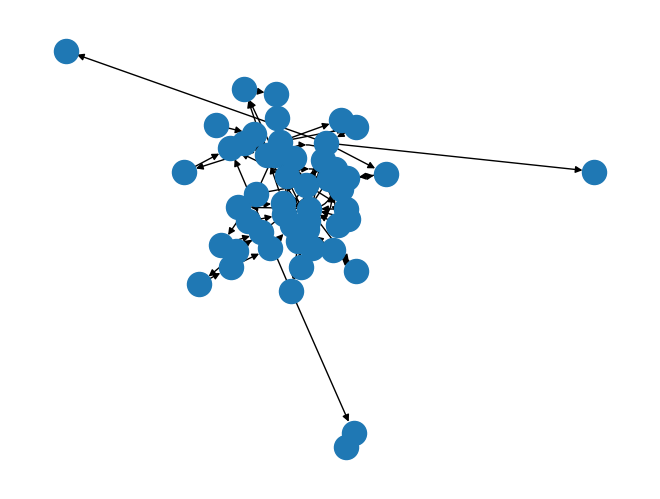

List of Frequent Patterns R9D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


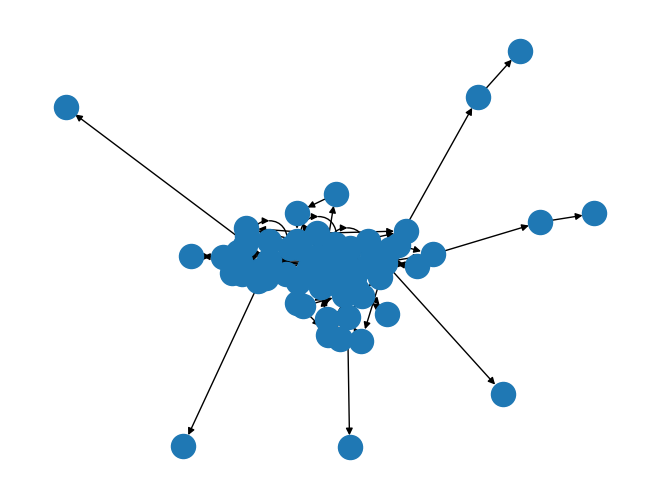

List of Frequent Patterns R9D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


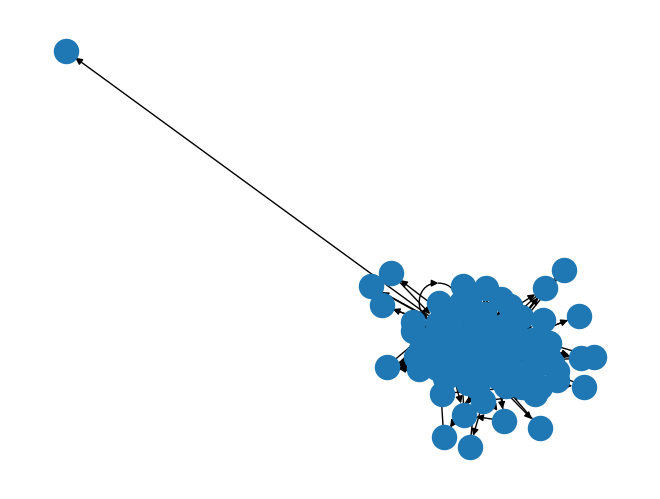

List of Frequent Patterns R10D1:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 5 	 31 		 0.04454022988505747 	 R10 	 D1 	 B2 B3 B1 B8 B6
1 	 4 	 31 		 0.04454022988505747 	 R10 	 D1 	 B3 B1 B8 B6
2 	 4 	 31 		 0.04454022988505747 	 R10 	 D1 	 B2 B3 B1 B6
3 	 4 	 11 		 0.015804597701149427 	 R10 	 D1 	 B2 B3 B1 B28
4 	 4 	 8 		 0.011494252873563218 	 R10 	 D1 	 B2 B3 B1 B48
5 	 4 	 7 		 0.010057471264367816 	 R10 	 D1 	 B2 B3 B1 B21
6 	 4 	 17 		 0.02442528735632184 	 R10 	 D1 	 B2 B3 B1 B13
7 	 4 	 13 		 0.01867816091954023 	 R10 	 D1 	 B2 B3 B1 B8
8 	 4 	 31 		 0.04454022988505747 	 R10 	 D1 	 B24 B1 B8 B6
9 	 3 	 31 		 0.04454022988505747 	 R10 	 D1 	 B3 B1 B6
10 	 3 	 11 		 0.015804597701149427 	 R10 	 D1 	 B3 B1 B28
11 	 3 	 8 		 0.011494252873563218 	 R10 	 D1 	 B3 B1 B48
12 	 3 	 7 		 0.010057471264367816 	 R10 	 D1 	 B3 B1 B21
13 	 3 	 17 		 0.02442528735632184 	 R10 	 D1 	 B3 B1 B13
14 	 3 	 13 		 0.01867816091954023 	 R10 	 D1 	 B3 B1 B8
15 	 3 	 31 		 0.04454022

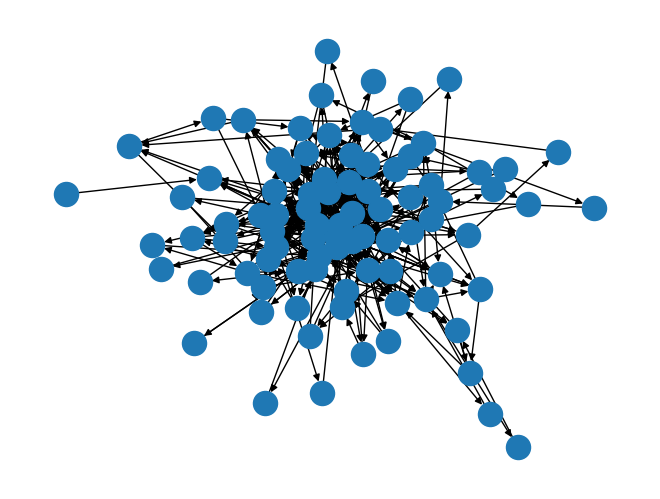

List of Frequent Patterns R10D2:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 12 		 0.028368794326241134 	 R10 	 D2 	 B35 B1 B8
1 	 3 	 12 		 0.028368794326241134 	 R10 	 D2 	 B3 B1 B8
2 	 2 	 12 		 0.028368794326241134 	 R10 	 D2 	 B1 B8
3 	 2 	 40 		 0.09456264775413711 	 R10 	 D2 	 B35 B1
4 	 2 	 40 		 0.09456264775413711 	 R10 	 D2 	 B3 B1
5 	 2 	 14 		 0.03309692671394799 	 R10 	 D2 	 B16 B11


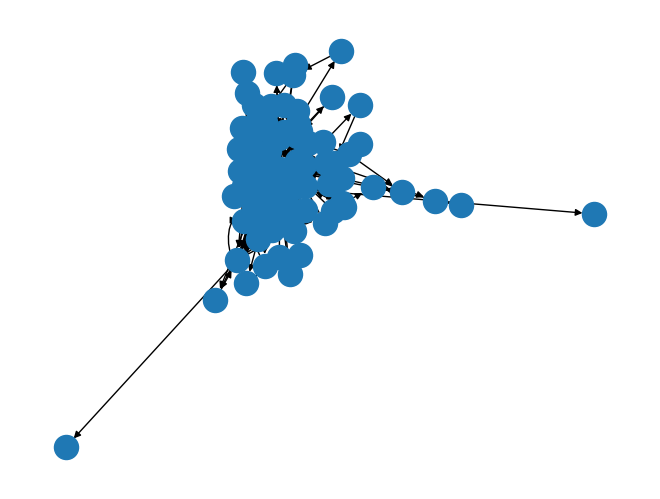

List of Frequent Patterns R10D3:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 3 	 8 		 0.05228758169934641 	 R10 	 D3 	 B3 B1 B8
1 	 2 	 8 		 0.05228758169934641 	 R10 	 D3 	 B1 B8
2 	 2 	 9 		 0.058823529411764705 	 R10 	 D3 	 B2 B9
3 	 2 	 28 		 0.1830065359477124 	 R10 	 D3 	 B3 B1


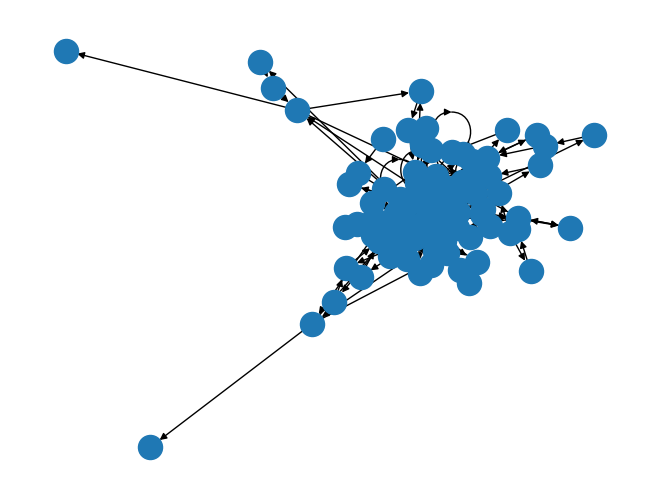

List of Frequent Patterns R10D4:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 25 		 0.16778523489932887 	 R10 	 D4 	 B3 B1


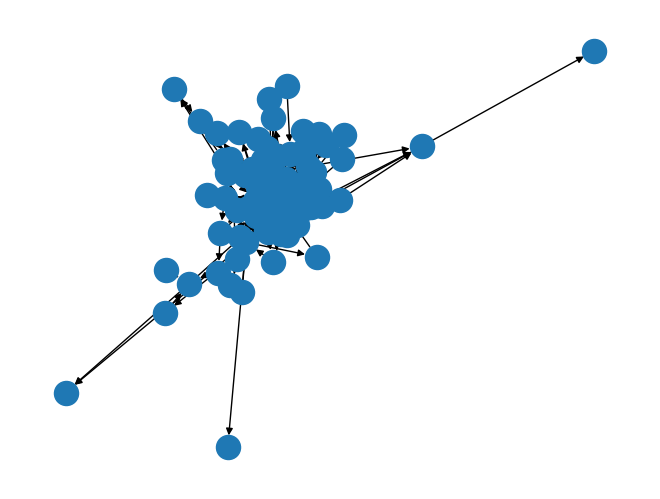

List of Frequent Patterns R10D5:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


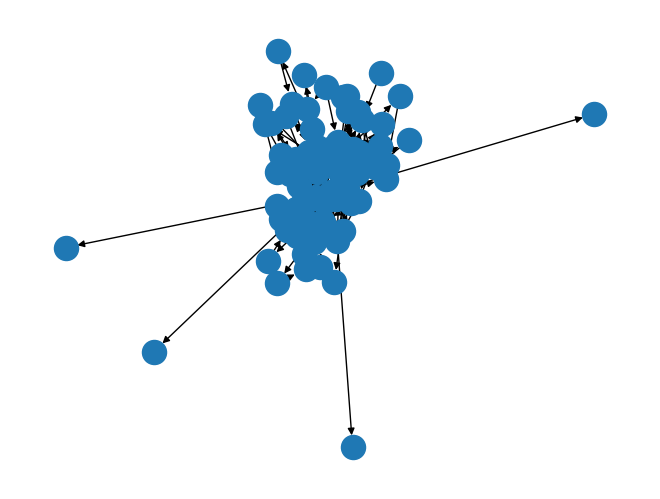

List of Frequent Patterns R10D6:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


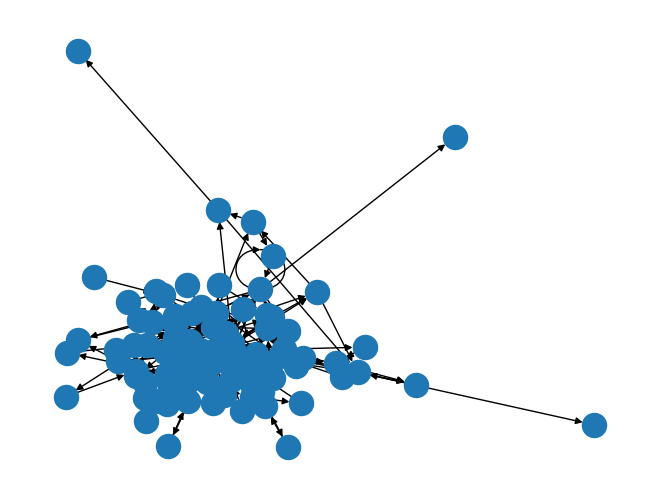

List of Frequent Patterns R10D7:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


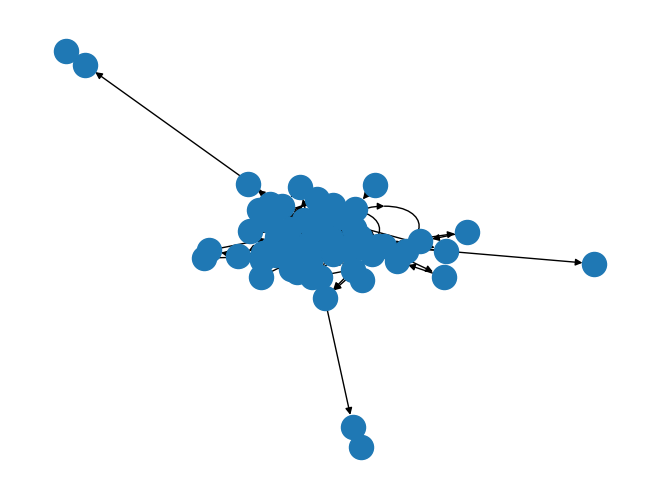

List of Frequent Patterns R10D8:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


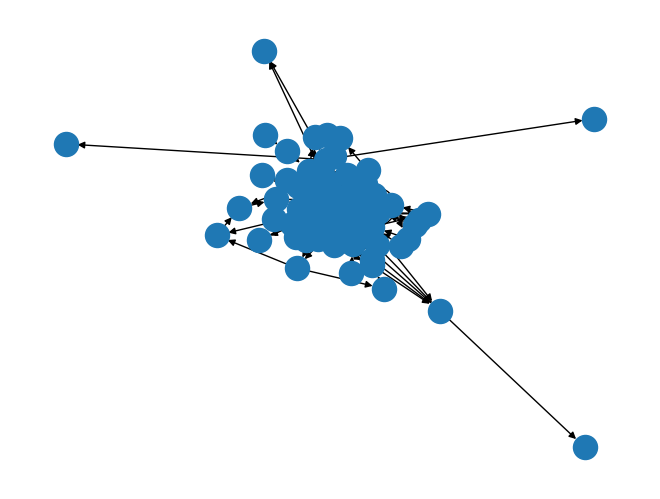

List of Frequent Patterns R10D9:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern
0 	 2 	 12 		 0.22641509433962265 	 R10 	 D9 	 B3 B1


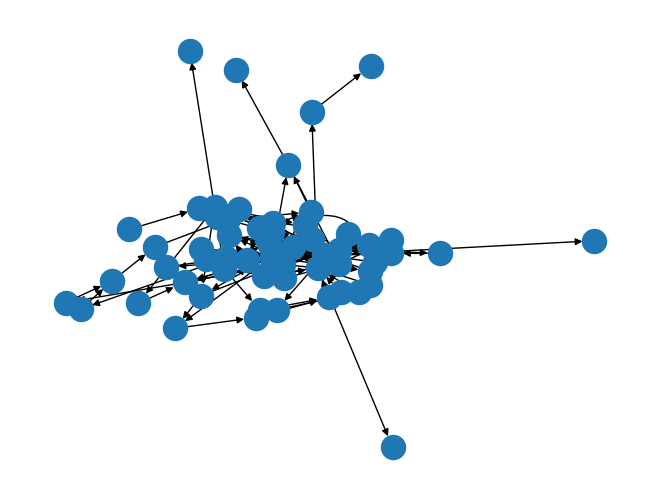

List of Frequent Patterns R10D10:-
S.No	Length	Frequency	Support	Rack_id	Datanode	Pattern


In [ ]:
import matplotlib.pyplot as plt
patterns=[]
for rack in range(1,11):
  ra='R'+str(rack)
  for ind in range(1,11):
    d='D'+str(ind)
    df_R1Di = pd.DataFrame(df.loc[(df['RackID'] == ra) & (df['DataNodeID'] == d)])

    r,c=df_R1Di.shape
    keys= df_R1Di.iloc[:,4]
    values=df_R1Di.iloc[:,5].str.split()

    web_access_sequence = dict(zip(keys, values))
    web_usage_graph = create_graph(web_access_sequence)
    nx.draw(web_usage_graph)
    plt.show()

    node_counts = {}
    edge_counts = {}
    for node in web_usage_graph.nodes():
        node_counts[node] = 0
    for edge in web_usage_graph.edges():
        edge_counts[edge] = 0

    for session_id in web_access_sequence:
        nodes = set(web_access_sequence[session_id])
        for node in nodes:
            if node in node_counts:
                node_counts[node] += 1
            else:
                node_counts[node] = 1
        for i in range(len(list(nodes))-1):
            current_page = list(nodes)[i]
            next_page = list(nodes)[i+1]
            if (current_page, next_page) in edge_counts:
                edge_counts[(current_page, next_page)] += 1
            else:
                edge_counts[(current_page, next_page)] = 1

    for node in web_usage_graph.nodes():
        web_usage_graph.nodes[node]['node_count'] = node_counts[node]
    for edge in web_usage_graph.edges():
        web_usage_graph.edges[edge]['link_count'] = edge_counts[edge]

    pruned_web_usage_graph=prune_graph(web_usage_graph,5)
    frequent_patterns_R1Di = Mine_graph(pruned_web_usage_graph,ra,d)
    patterns+=frequent_patterns_R1Di
    print("List of Frequent Patterns R"+str(rack)+"D"+str(ind)+":-")
    print("S.No\tLength\tFrequency\tSupport\tRack_id\tDatanode\tPattern")
    for i in range(0,len(frequent_patterns_R1Di)):
        print(i,"\t",frequent_patterns_R1Di[i][2],"\t",frequent_patterns_R1Di[i][1],"\t\t",frequent_patterns_R1Di[i][3],"\t",frequent_patterns_R1Di[i][4],"\t",frequent_patterns_R1Di[i][5],"\t",*frequent_patterns_R1Di[i][0])
fp = pd.DataFrame(patterns,columns=['Pattern','Frequency','Length','Support','Rack_id','Datanode'])